## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Business Understanding

The company wants to enter the movie production industry and is looking for actionable insights on the types of movies that are likely to succeed. They have tasked us with exploring current box office data to answer these questions:

    Success Metrics
- Revenue: Total box-office income (Worldwide gross).
- ROI: A profitability metric calculated as ;

    ROI = Worldwide Revenue−Production Budget / Production Budget 
- Ratings: The average rating a movie receives (provided as a pre-calculated value in the dataset).

    Key Business Questions

1. Which Movie Genres Are the Most Profitable in Terms of ROI and Revenue?
   - Identifying the genres that provide the highest financial returns and audience appeal.
2. How Does Production Budget Impact Movie Success Metrics (Ratings, ROI, and Revenue)?
   - Exploring how budget size correlates with movie success metrics to optimize spending.
3. How Does Runtime Affect Success Metrics and Viewer Engagement?
   - Investigating whether runtime influences success metrics like ratings and audience engagement (votes).

# Data Understanding

1. CSV Data (movie_statistic_dataset.csv)
Here is a preview of the key columns in this CSV file:
- movie_title: Title of the movie.
- genres: Genres of the movie (Action, Adventure, Sci-Fi, etc.).
- Production budget $: The production budget in USD.
- Worldwide gross $: Total worldwide gross revenue in USD.
- movie_averageRating: Average user rating for the movie.
- approval_Index: A custom index indicating overall approval of the movie.
- runtime_minutes: Length of the movie in minutes. 

2. SQL Database(im.db)
- Table Name
- movie_basics
- directors
- known_for
- movie_akas
- movie_ratings
- persons
- principals
- writers

In [2]:
import pandas as pd

# Load the CSV file
csv_file_path = '/Users/jeesoojhun/Documents/Flatiron/Phase-2-Project-Jeesoo/zippedData/movie_statistic_dataset.csv'
movie_stats_df = pd.read_csv(csv_file_path)

# Preview the dataset
movie_stats_df.head()


,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.0,James Cameron,"writer,producer,director",1954,alive,7.8,277543.0,7.061101,460000000,667830256,2265935552
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.0,-,-,-,-,8.4,1143642.0,8.489533,400000000,858373000,2794731755
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,"Action,Adventure,Fantasy",137.0,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.6,533763.0,6.272064,379000000,241071802,1045713802
3,Avengers: Age of Ultron,2015-04-22,"Action,Adventure,Sci-Fi",141.0,Joss Whedon,"writer,producer,director",1964,alive,7.3,870573.0,7.214013,365000000,459005868,1395316979
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.0,-,-,-,-,8.4,1091968.0,8.460958,300000000,678815482,2048359754


In [9]:
movie_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_title           4380 non-null   object 
 1   production_date       4380 non-null   object 
 2   genres                4380 non-null   object 
 3   runtime_minutes       4380 non-null   float64
 4   director_name         4380 non-null   object 
 5   director_professions  4380 non-null   object 
 6   director_birthYear    4380 non-null   object 
 7   director_deathYear    4380 non-null   object 
 8   movie_averageRating   4380 non-null   float64
 9   movie_numerOfVotes    4380 non-null   float64
 10  approval_Index        4380 non-null   float64
 11  Production budget $   4380 non-null   int64  
 12  Domestic gross $      4380 non-null   int64  
 13  Worldwide gross $     4380 non-null   int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 479.2+ KB


In [8]:
movie_stats_df.isnull().sum()

movie_title             0
production_date         0
genres                  0
runtime_minutes         0
director_name           0
director_professions    0
director_birthYear      0
director_deathYear      0
movie_averageRating     0
movie_numerOfVotes      0
approval_Index          0
Production budget $     0
Domestic gross $        0
Worldwide gross $       0
dtype: int64

In [5]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('/Users/jeesoojhun/Documents/Flatiron/Phase-2-Project-Jeesoo/zippedData/im.db')

# List all tables in the database
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(tables_query, conn)
print(tables)


            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


* Key Tables for Analysis
1. movie_basics: Contains movie information.
2. movie_ratings: Contains movie ratings.
3. directors: Contains director information.
4. persons: Contains details of persons (to link with directors).
5. writers: Contains writer information.
6. movie_akas: Contains alternate titles.

In [6]:
# Load the key tables from the database
movie_basics_df = pd.read_sql("SELECT movie_id, primary_title, start_year, runtime_minutes, genres FROM movie_basics;", conn)
movie_ratings_df = pd.read_sql("SELECT movie_id, averagerating, numvotes FROM movie_ratings;", conn)
directors_df = pd.read_sql("SELECT movie_id, person_id FROM directors;", conn)
writers_df = pd.read_sql("SELECT movie_id, person_id FROM writers;", conn)
persons_df = pd.read_sql("SELECT person_id, primary_name FROM persons;", conn)
movie_akas_df = pd.read_sql("SELECT movie_id, title, region, language FROM movie_akas;", conn)


# Data Preparation

1. Merge the Tables based on movie_id and person_id where appropriate.

In [7]:
# Merge movie_basics and movie_ratings on movie_id
merged_imdb_df = pd.merge(movie_basics_df, movie_ratings_df, on='movie_id', how='inner')

# Merge directors with persons to get director names, then merge with main dataset
directors_with_names_df = pd.merge(directors_df, persons_df, on='person_id', how='left')
merged_imdb_df = pd.merge(merged_imdb_df, directors_with_names_df, on='movie_id', how='left', suffixes=('', '_director'))

# Merge writers with persons to get writer names, then merge with main dataset
writers_with_names_df = pd.merge(writers_df, persons_df, on='person_id', how='left')
merged_imdb_df = pd.merge(merged_imdb_df, writers_with_names_df, on='movie_id', how='left', suffixes=('', '_writer'))

# Merge movie_akas for title, region, and language information
merged_imdb_df = pd.merge(merged_imdb_df, movie_akas_df, on='movie_id', how='left', suffixes=('', '_akas'))

# Check the final merged dataset
print(merged_imdb_df.shape)
print(merged_imdb_df.head())


(86466148, 14)
    movie_id primary_title  start_year  runtime_minutes              genres  \
0  tt0063540     Sunghursh        2013            175.0  Action,Crime,Drama   
1  tt0063540     Sunghursh        2013            175.0  Action,Crime,Drama   
2  tt0063540     Sunghursh        2013            175.0  Action,Crime,Drama   
3  tt0063540     Sunghursh        2013            175.0  Action,Crime,Drama   
4  tt0063540     Sunghursh        2013            175.0  Action,Crime,Drama   

   averagerating  numvotes  person_id         primary_name person_id_writer  \
0            7.0        77  nm0712540  Harnam Singh Rawail        nm0023551   
1            7.0        77  nm0712540  Harnam Singh Rawail        nm0023551   
2            7.0        77  nm0712540  Harnam Singh Rawail        nm0023551   
3            7.0        77  nm0712540  Harnam Singh Rawail        nm0023551   
4            7.0        77  nm0712540  Harnam Singh Rawail        nm0023551   

  primary_name_writer      title re

In [10]:
merged_imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86466148 entries, 0 to 86466147
Data columns (total 14 columns):
 #   Column               Dtype  
---  ------               -----  
 0   movie_id             object 
 1   primary_title        object 
 2   start_year           int64  
 3   runtime_minutes      float64
 4   genres               object 
 5   averagerating        float64
 6   numvotes             int64  
 7   person_id            object 
 8   primary_name         object 
 9   person_id_writer     object 
 10  primary_name_writer  object 
 11  title                object 
 12  region               object 
 13  language             object 
dtypes: float64(2), int64(2), object(10)
memory usage: 9.0+ GB


In [13]:
merged_imdb_df.isnull().sum()

movie_id                      0
primary_title                 0
start_year                    0
runtime_minutes         2359211
genres                    24975
averagerating                 0
numvotes                      0
person_id                  1211
primary_name               1235
person_id_writer          25692
primary_name_writer       25694
title                    118816
region                  9494544
language               81158967
dtype: int64

2. Data Cleaning

- Remove duplicates: In case multiple records exist for the same movie.
- Handle missing values: You can either remove rows with missing critical information (e.g., missing ratings) or fill in missing values.
- Convert data types: Ensure columns like runtime_minutes, averagerating, and numvotes are in the correct format for analysis.
- Exploding the genre column: Since the genres column contains multiple genres separated by commas (e.g., "Action, Crime, Drama"), we will split this into individual rows for more accurate analysis.

In [12]:
# Remove duplicates
movie_stats_df.drop_duplicates(inplace=True)

# Explode the genres column
movie_stats_df['genres'] = movie_stats_df['genres'].str.split(',')
movie_stats_df = movie_stats_df.explode('genres')

# Check the cleaned dataset
print(movie_stats_df.info())
print(movie_stats_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 11326 entries, 0 to 4379
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_title           11326 non-null  object 
 1   production_date       11326 non-null  object 
 2   genres                11326 non-null  object 
 3   runtime_minutes       11326 non-null  float64
 4   director_name         11326 non-null  object 
 5   director_professions  11326 non-null  object 
 6   director_birthYear    11326 non-null  object 
 7   director_deathYear    11326 non-null  object 
 8   movie_averageRating   11326 non-null  float64
 9   movie_numerOfVotes    11326 non-null  float64
 10  approval_Index        11326 non-null  float64
 11  Production budget $   11326 non-null  int64  
 12  Domestic gross $      11326 non-null  int64  
 13  Worldwide gross $     11326 non-null  int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 1.3+ MB
None
              

In [14]:
# Remove duplicates
merged_imdb_df.drop_duplicates(inplace=True)

# Handle missing values
merged_imdb_df['runtime_minutes'].fillna(merged_imdb_df['runtime_minutes'].median(), inplace=True)
merged_imdb_df['averagerating'].fillna(merged_imdb_df['averagerating'].mean(), inplace=True)
merged_imdb_df.dropna(subset=['primary_title', 'genres'], inplace=True)

# Explode the genres column
merged_imdb_df['genres'] = merged_imdb_df['genres'].str.split(',')
merged_imdb_df = merged_imdb_df.explode('genres')

# Check the cleaned dataset
print(merged_imdb_df.info())
print(merged_imdb_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1552724 entries, 0 to 86466147
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   movie_id             1552724 non-null  object 
 1   primary_title        1552724 non-null  object 
 2   start_year           1552724 non-null  int64  
 3   runtime_minutes      1552724 non-null  float64
 4   genres               1552724 non-null  object 
 5   averagerating        1552724 non-null  float64
 6   numvotes             1552724 non-null  int64  
 7   person_id            1551152 non-null  object 
 8   primary_name         1551128 non-null  object 
 9   person_id_writer     1512627 non-null  object 
 10  primary_name_writer  1512626 non-null  object 
 11  title                1541549 non-null  object 
 12  region               1324701 non-null  object 
 13  language             215677 non-null   object 
dtypes: float64(2), int64(2), object(10)
memory usage: 177.

In [15]:
merged_imdb_df.isnull().sum()

movie_id                     0
primary_title                0
start_year                   0
runtime_minutes              0
genres                       0
averagerating                0
numvotes                     0
person_id                 1572
primary_name              1596
person_id_writer         40097
primary_name_writer      40098
title                    11175
region                  228023
language               1337047
dtype: int64

In [17]:
# Filling missing values for non-critical columns
# For person_id, primary_name (directors and writers) and title, fill with 'Unknown'
merged_imdb_df['person_id'] = merged_imdb_df['person_id'].fillna('Unknown')
merged_imdb_df['primary_name'] = merged_imdb_df['primary_name'].fillna('Unknown')
merged_imdb_df['person_id_writer'] = merged_imdb_df['person_id_writer'].fillna('Unknown')
merged_imdb_df['primary_name_writer'] = merged_imdb_df['primary_name_writer'].fillna('Unknown')
merged_imdb_df['title'] = merged_imdb_df['title'].fillna('Unknown')

# For region and language, given the large number of missing values, fill with 'Unknown'
merged_imdb_df['region'] = merged_imdb_df['region'].fillna('Unknown')
merged_imdb_df['language'] = merged_imdb_df['language'].fillna('Unknown')

# Dropping rows with critical missing values (e.g., if needed for writer analysis)
imdb_cleaned_df = merged_imdb_df.dropna(subset=['person_id', 'primary_name', 'person_id_writer', 'primary_name_writer'])

# Check the cleaned dataframe to confirm
print(imdb_cleaned_df.isnull().sum())
print(imdb_cleaned_df.head())


movie_id               0
primary_title          0
start_year             0
runtime_minutes        0
genres                 0
averagerating          0
numvotes               0
person_id              0
primary_name           0
person_id_writer       0
primary_name_writer    0
title                  0
region                 0
language               0
dtype: int64
    movie_id primary_title  start_year  runtime_minutes  genres  \
0  tt0063540     Sunghursh        2013            175.0  Action   
0  tt0063540     Sunghursh        2013            175.0   Crime   
0  tt0063540     Sunghursh        2013            175.0   Drama   
1  tt0063540     Sunghursh        2013            175.0  Action   
1  tt0063540     Sunghursh        2013            175.0   Crime   

   averagerating  numvotes  person_id         primary_name person_id_writer  \
0            7.0        77  nm0712540  Harnam Singh Rawail        nm0023551   
0            7.0        77  nm0712540  Harnam Singh Rawail        nm0023551 

In [56]:
# Check the columns in each dataset
print(movie_stats_df.columns)
print(imdb_cleaned_df.columns)


Index(['movie_title', 'production_date', 'genres', 'runtime_minutes',
       'director_name', 'director_professions', 'director_birthYear',
       'director_deathYear', 'movie_averageRating', 'movie_numerOfVotes',
       'approval_Index', 'Production budget $', 'Domestic gross $',
       'Worldwide gross $', 'ROI'],
      dtype='object')
Index(['movie_id', 'primary_title', 'start_year', 'runtime_minutes', 'genres',
       'averagerating', 'numvotes', 'person_id', 'primary_name',
       'person_id_writer', 'primary_name_writer', 'title', 'region',
       'language'],
      dtype='object')


 try to merge them using a combination of movie_title (from movie_stats_df) and primary_title (from imdb_cleaned_df), as these columns likely represent the movie titles in each dataset.

> Preparing for the Merge

In [57]:
# Clean and prepare the movie titles
movie_stats_df['movie_title_clean'] = movie_stats_df['movie_title'].str.lower().str.strip()
imdb_cleaned_df['primary_title_clean'] = imdb_cleaned_df['primary_title'].str.lower().str.strip()


In [58]:
# Extract the year from the 'production_date' if it's in datetime format
movie_stats_df['production_year'] = pd.to_datetime(movie_stats_df['production_date'], errors='coerce').dt.year

# Ensure 'start_year' in imdb_cleaned_df is in the right format
imdb_cleaned_df['start_year'] = imdb_cleaned_df['start_year'].astype(int)


In [59]:
# Merge the two datasets using cleaned titles and year
merged_df = pd.merge(movie_stats_df, imdb_cleaned_df, 
                     how='inner', 
                     left_on=['movie_title_clean', 'production_year'], 
                     right_on=['primary_title_clean', 'start_year'])

# Preview the merged dataset
print(merged_df.head())


         movie_title production_date genres_x  runtime_minutes_x  \
0  Avengers: Endgame      2019-04-23   Action              181.0   
1  Avengers: Endgame      2019-04-23   Action              181.0   
2  Avengers: Endgame      2019-04-23   Action              181.0   
3  Avengers: Endgame      2019-04-23   Action              181.0   
4  Avengers: Endgame      2019-04-23   Action              181.0   

  director_name director_professions director_birthYear director_deathYear  \
0             -                    -                  -                  -   
1             -                    -                  -                  -   
2             -                    -                  -                  -   
3             -                    -                  -                  -   
4             -                    -                  -                  -   

   movie_averageRating  movie_numerOfVotes  ...  averagerating  numvotes  \
0                  8.4           1143642.0  ..

In [63]:
# Check for duplicates in the merged dataset
merged_df = merged_df.drop_duplicates()
print(f"Number of duplicate rows after merging: {duplicates}")

# Drop duplicates if needed
merged_df = merged_df.drop_duplicates()

# Check for missing values in the merged dataset
missing_values = merged_df.isnull().sum()
print(missing_values)


Number of duplicate rows after merging: 0
movie_title             0
production_date         0
genres_x                0
runtime_minutes_x       0
director_name           0
director_professions    0
director_birthYear      0
director_deathYear      0
movie_averageRating     0
movie_numerOfVotes      0
approval_Index          0
Production budget $     0
Domestic gross $        0
Worldwide gross $       0
ROI                     0
movie_title_clean       0
production_year         0
movie_id                0
primary_title           0
start_year              0
runtime_minutes_y       0
genres_y                0
averagerating           0
numvotes                0
person_id               0
primary_name            0
person_id_writer        0
primary_name_writer     0
title                   0
region                  0
language                0
primary_title_clean     0
dtype: int64


In [64]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916650 entries, 0 to 916649
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movie_title           916650 non-null  object 
 1   production_date       916650 non-null  object 
 2   genres_x              916650 non-null  object 
 3   runtime_minutes_x     916650 non-null  float64
 4   director_name         916650 non-null  object 
 5   director_professions  916650 non-null  object 
 6   director_birthYear    916650 non-null  object 
 7   director_deathYear    916650 non-null  object 
 8   movie_averageRating   916650 non-null  float64
 9   movie_numerOfVotes    916650 non-null  float64
 10  approval_Index        916650 non-null  float64
 11  Production budget $   916650 non-null  int64  
 12  Domestic gross $      916650 non-null  int64  
 13  Worldwide gross $     916650 non-null  int64  
 14  ROI                   916650 non-null  float64
 15  

In [68]:
# Drop duplicates based on 'movie_title' and 'Worldwide gross $' to ensure uniqueness
merged_df_cleaned = merged_df.drop_duplicates(subset=['movie_title', 'Worldwide gross $'])

# Check if duplicates were removed
print(f"Number of duplicate rows removed: {merged_df.duplicated(subset=['movie_title', 'Worldwide gross $']).sum()}")


Number of duplicate rows removed: 915240


In [69]:
merged_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1410 entries, 0 to 916647
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_title           1410 non-null   object 
 1   production_date       1410 non-null   object 
 2   genres_x              1410 non-null   object 
 3   runtime_minutes_x     1410 non-null   float64
 4   director_name         1410 non-null   object 
 5   director_professions  1410 non-null   object 
 6   director_birthYear    1410 non-null   object 
 7   director_deathYear    1410 non-null   object 
 8   movie_averageRating   1410 non-null   float64
 9   movie_numerOfVotes    1410 non-null   float64
 10  approval_Index        1410 non-null   float64
 11  Production budget $   1410 non-null   int64  
 12  Domestic gross $      1410 non-null   int64  
 13  Worldwide gross $     1410 non-null   int64  
 14  ROI                   1410 non-null   float64
 15  movie_title_clean     14

# Exploratory Data Analysis

## Q1. Which movies are the top performers by Sucess Metrics (ROI, Revenue and Ratings)?

1. Top 10 movies by ROI & Top 10 movies by Revenue & Top 10 movies by Average Rating

/var/folders/tc/1ms7n2d57vv5dn_343mwj34r0000gn/T/ipykernel_26456/1751119261.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='movie_title', y='ROI', data=top_10_movies_by_roi, palette='Blues_d')


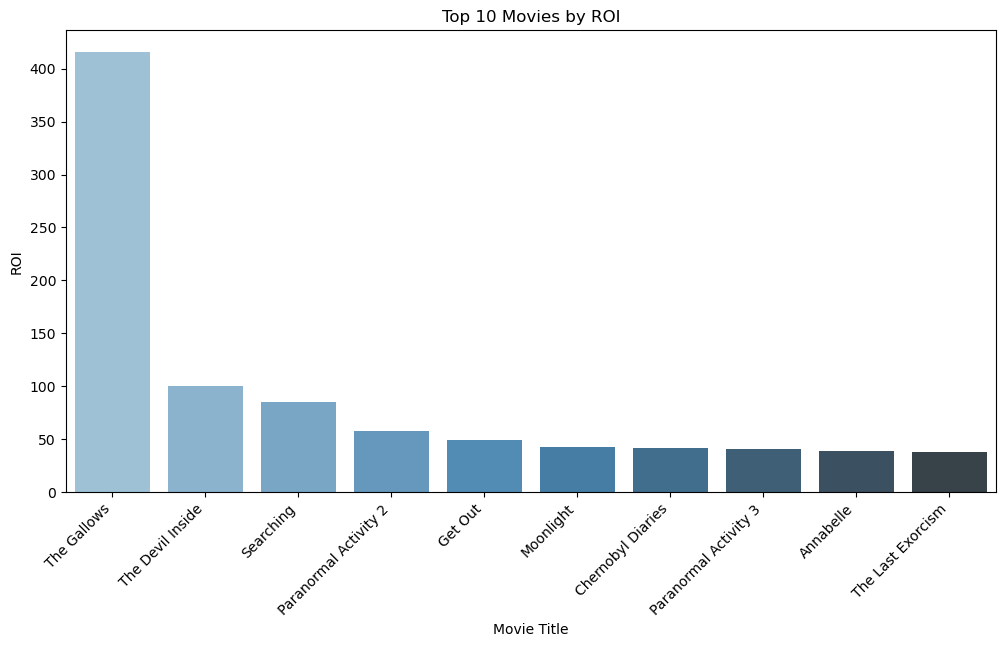

/var/folders/tc/1ms7n2d57vv5dn_343mwj34r0000gn/T/ipykernel_26456/1751119261.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='movie_title', y='Worldwide gross $', data=top_10_movies_by_revenue, palette='Blues_d')


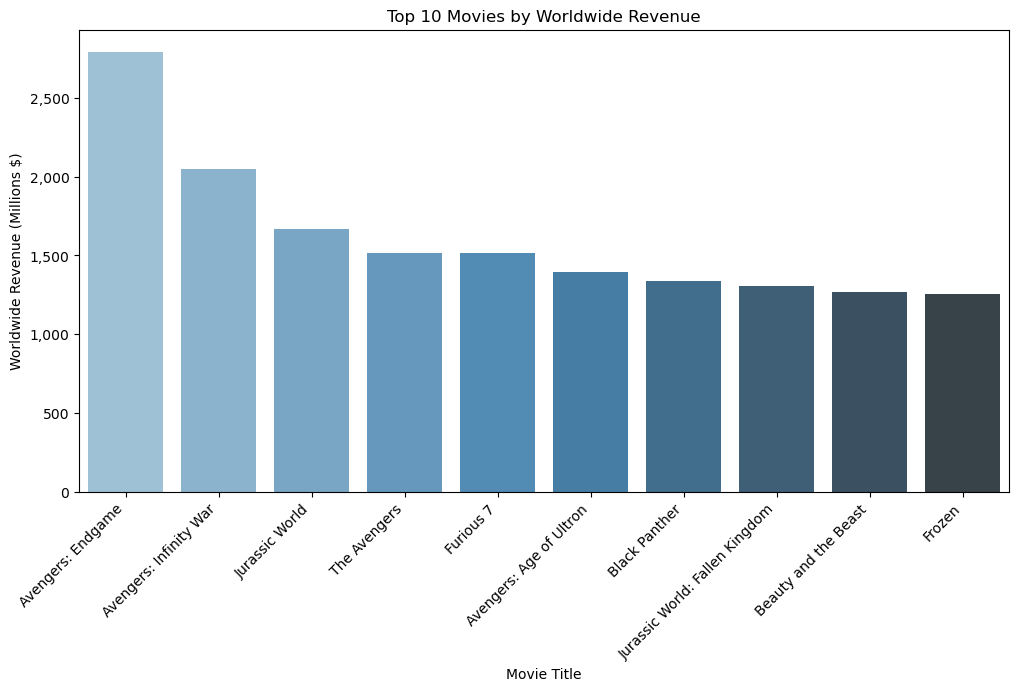

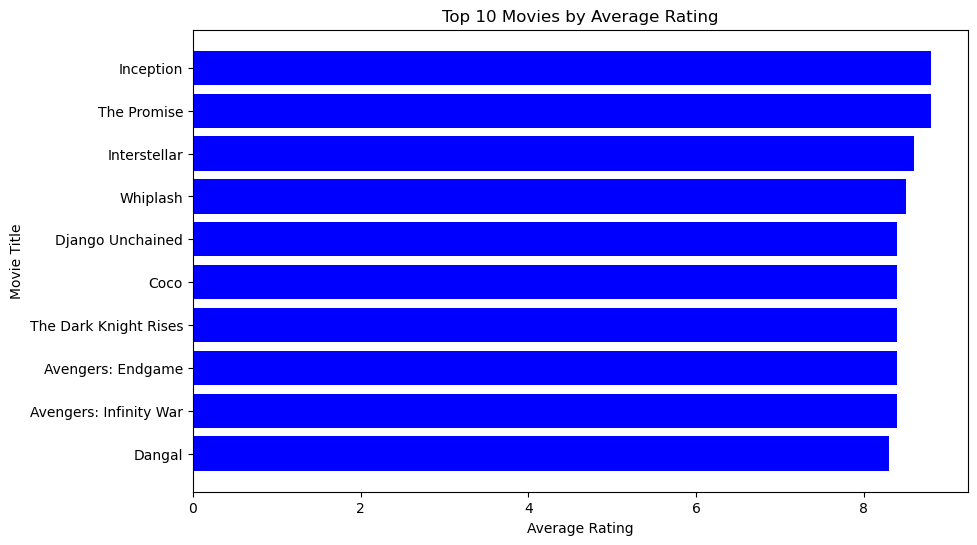

In [197]:
# Sort for top 10 movies by ROI
top_10_movies_by_roi = merged_df_cleaned.sort_values(by='ROI', ascending=False).head(10)

# Sort for top 10 movies by Revenue
top_10_movies_by_revenue = merged_df_cleaned.sort_values(by='Worldwide gross $', ascending=False).head(10)

# Sort for top 10 movies by Rating
top_performers_by_ratings = merged_df_cleaned[['movie_title', 'movie_averageRating']].sort_values(by='movie_averageRating', ascending=False).head(10)


# Visualize the top 10 movies by ROI
plt.figure(figsize=(12, 6))
sns.barplot(x='movie_title', y='ROI', data=top_10_movies_by_roi, palette='Blues_d')
plt.xticks(rotation=45, ha="right")
plt.title('Top 10 Movies by ROI')
plt.xlabel('Movie Title')
plt.ylabel('ROI')
plt.show()

# Visualize the top 10 movies by revenue (in millions)
plt.figure(figsize=(12, 6))
sns.barplot(x='movie_title', y='Worldwide gross $', data=top_10_movies_by_revenue, palette='Blues_d')
plt.xticks(rotation=45, ha="right")
plt.title('Top 10 Movies by Worldwide Revenue')
plt.xlabel('Movie Title')
plt.ylabel('Worldwide Revenue (Millions $)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1e6))))
plt.show()

# Top 10 Movies by Average Rating
plt.figure(figsize=(10, 6))
plt.barh(top_performers_by_ratings['movie_title'], top_performers_by_ratings['movie_averageRating'], color='Blue')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.title('Top 10 Movies by Average Rating')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


> Insights : 
>1. Top 10 Movies by ROI : 
>- The Gallows stands out with an exceptionally high ROI, above 400%, which suggests it was produced on a low budget but generated significant returns.
>- Movies like The Devil Inside and Searching also show strong ROI, emphasizing the potential profitability of lower-budget films, especially in genres like horror and thriller. 

>2. Top 10 Movies by Revenue:
>- Avengers: Endgame leads with over $2.7 billion in global revenue, followed by Avengers: Infinity War and Jurassic World. These films tend to be part of large franchises with substantial fan bases, often within the action, sci-fi, and fantasy genres.
>- While these movies have massive production budgets, their box-office performance justifies the investment.

>3. Top 10 Movies by Average Rating:
>- Movies like Inception, The Promise, and Interstellar are rated highest by critics and audiences, indicating a strong critical reception. These movies tend to be longer in runtime and often feature deep storytelling, well-executed cinematography, and intricate plots.

## Q2 : What Are the Most Profitable Genres in Terms of ROI? 

1. Top 10 Most Profitable Genres by ROI

In [128]:
# Group by Genre and Calculate Average ROI
# Group by genres and calculate average ROI and average production budget
genre_profitability = merged_df_cleaned.groupby('genres_x').agg(
    avg_roi=('ROI', 'mean'),
    avg_budget=('Production budget $', 'mean'),
    movie_count=('movie_title', 'count')
).reset_index()

# Sort the genres by ROI in descending order to find the most profitable ones
top_profitable_genres = genre_profitability.sort_values(by='avg_roi', ascending=False).head(10)

# Display the top 10 most profitable genres based on ROI
print(top_profitable_genres[['genres_x', 'avg_roi', 'avg_budget', 'movie_count']])


     genres_x    avg_roi    avg_budget  movie_count
9      Horror  18.318245  1.161308e+07           65
15   Thriller   5.681069  2.150000e+06            2
14     Sci-Fi   4.761664  2.700000e+07            1
8     Fantasy   3.344939  8.966667e+07            6
2   Animation   3.263167  2.740000e+07            5
7       Drama   3.140583  1.885478e+07          236
1   Adventure   2.817347  8.493229e+07          144
4      Comedy   2.523365  2.337197e+07          290
3   Biography   2.063612  2.348871e+07          124
0      Action   1.896242  8.116473e+07          455


2. Statistical Testing (ANOVA, Tukey HSD Test)

        2.1 ANOVA

We'll calculate the average ROI per genre and perform an ANOVA test to see if certain genres are statistically more profitable.

Hypothesis Setup:

1. Null Hypothesis (H0): There is no significant difference in ROI between different genres. In other words, the ROI for movies across genres is the same.

2. Alternative Hypothesis (H1): There is a significant difference in ROI between genres. In other words, Some genres have a higher or lower ROI than others.

ANOVA p-value for Genre ROI differences: 6.943916507025847e-16


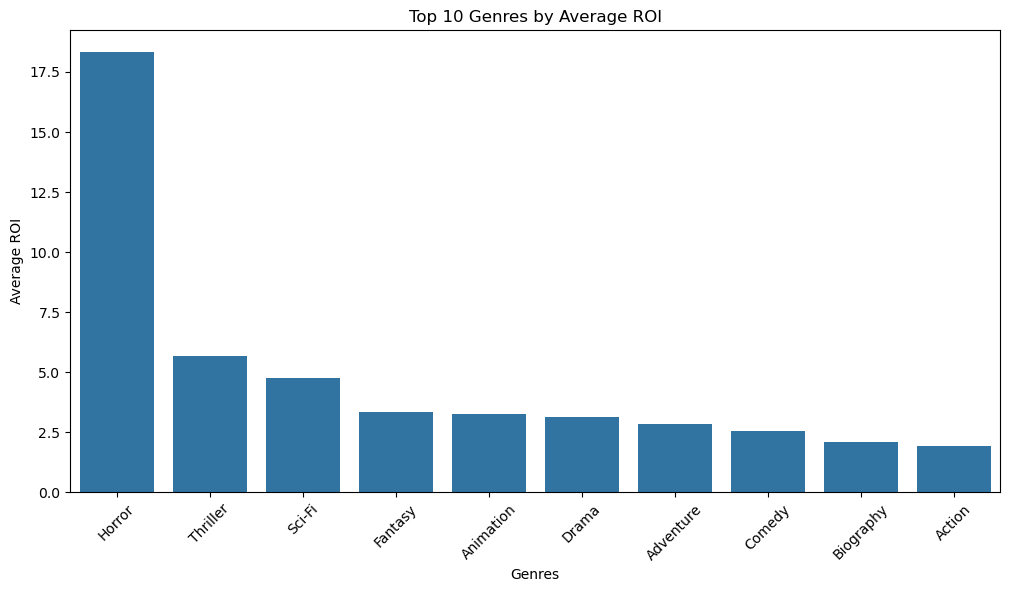

In [219]:
# Group by genres and calculate average ROI
genre_roi_analysis = merged_df_cleaned.groupby('genres_x').agg(
    avg_roi=('ROI', 'mean'),
    avg_revenue=('Worldwide gross $', 'mean'),
    movie_count=('movie_title', 'count')
).reset_index()

# Perform ANOVA to test if genres have significantly different ROI
from scipy import stats
anova_genre_roi = stats.f_oneway(*[merged_df_cleaned[merged_df_cleaned['genres_x'] == genre]['ROI'].dropna() for genre in merged_df_cleaned['genres_x'].unique()])

print(f"ANOVA p-value for Genre ROI differences: {anova_genre_roi.pvalue}")

# Visualize top genres by ROI
plt.figure(figsize=(12, 6))
sns.barplot(x='genres_x', y='avg_roi', data=genre_roi_analysis.sort_values(by='avg_roi', ascending=False).head(10))
plt.xticks(rotation=45)
plt.title('Top 10 Genres by Average ROI')
plt.xlabel('Genres')
plt.ylabel('Average ROI')
plt.show()


> Insights :  
> - Genres like Horror, Thriller, or Sci-Fi often rank high in terms of ROI due to their typically lower production budgets but consistent audience demand.
>
> - ANOVA results will show whether different genres have significantly different levels of profitability, helping decision-makers focus on the most profitable genres. 
>
> - Given that the p-value is much smaller than 0.05, we reject the null hypothesis (H0) and accept the alternative hypothesis (H1). There is a significant difference in ROI between genres. This means that certain genres tend to have higher or lower ROI than others.

        2.2 Tukey Test

Now that we know there is a significant difference, the next step is to perform a post-hoc analysis to determine which genres are significantly different from each other. This could be done using a Tukey HSD (Honestly Significant Difference) test to compare each genre pair.

In [131]:
#Prepare the Data
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

# Drop missing values in ROI and genres
tukey_data = merged_df_cleaned[['genres_x', 'ROI']].dropna()

# Prepare data for the test
tukey_data['genres_x'] = tukey_data['genres_x'].astype(str)  # Ensure genres is of type string


In [132]:
# Perform Tukey HSD test
tukey = pairwise_tukeyhsd(endog=tukey_data['ROI'],      # Dependent variable
                          groups=tukey_data['genres_x'],  # Independent variable (genres)
                          alpha=0.05)                  # Significance level

# Convert the Tukey results into a DataFrame
tukey_results_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Display the full Tukey results
print(tukey_results_df)


      group1     group2  meandiff  p-adj    lower    upper  reject
0     Action  Adventure    0.9211    1.0  -3.0644   4.9066   False
1     Action  Animation    1.3669    1.0 -17.3762  20.1100   False
2     Action  Biography    0.1674    1.0  -4.0552   4.3899   False
3     Action     Comedy    0.6271    1.0  -2.5049   3.7592   False
4     Action      Crime   -0.3618    1.0  -6.0868   5.3632   False
..       ...        ...       ...    ...      ...      ...     ...
115  Mystery     Sci-Fi    4.3145    1.0 -43.8163  52.4452   False
116  Mystery   Thriller    5.2339    1.0 -32.8169  43.2846   False
117  Romance     Sci-Fi    3.2332    1.0 -55.7148  62.1811   False
118  Romance   Thriller    4.1526    1.0 -46.8978  55.2030   False
119   Sci-Fi   Thriller    0.9194    1.0 -50.1310  51.9698   False

[120 rows x 7 columns]


In [133]:
# Check the type of values in the 'reject' column
print(tukey_results_df['reject'].unique())

# If needed, convert 'reject' to a boolean column (if it contains string values)
tukey_results_df['reject'] = tukey_results_df['reject'].astype(bool)

# Now filter for rows where 'reject' is True
significant_differences = tukey_results_df[tukey_results_df['reject'] == True]

# Display the significant differences
print(significant_differences)


[False  True]
         group1  group2  meandiff  p-adj    lower    upper  reject
8        Action  Horror   16.4220    0.0  10.8950  21.9490    True
22    Adventure  Horror   15.5009    0.0   9.2723  21.7295    True
47    Biography  Horror   16.2546    0.0   9.8717  22.6375    True
58       Comedy  Horror   15.7949    0.0  10.0747  21.5151    True
68        Crime  Horror   16.7838    0.0   9.3214  24.2461    True
77  Documentary  Horror   17.7622    0.0   6.1295  29.3949    True
85        Drama  Horror   15.1777    0.0   9.3389  21.0165    True


> Insights: If reject = True for a genre pair, it means that there is a statistically significant difference in ROI between those two genres.

## Q3: How does the production budget affect movie Success Metrics (Revenue, Ratings)?

We'll test the relationship between production budget and success metrics such as ratings, Worldwide revenue, and ROI.

1. Corrleation :  See how well budget correlates with other success metrics.

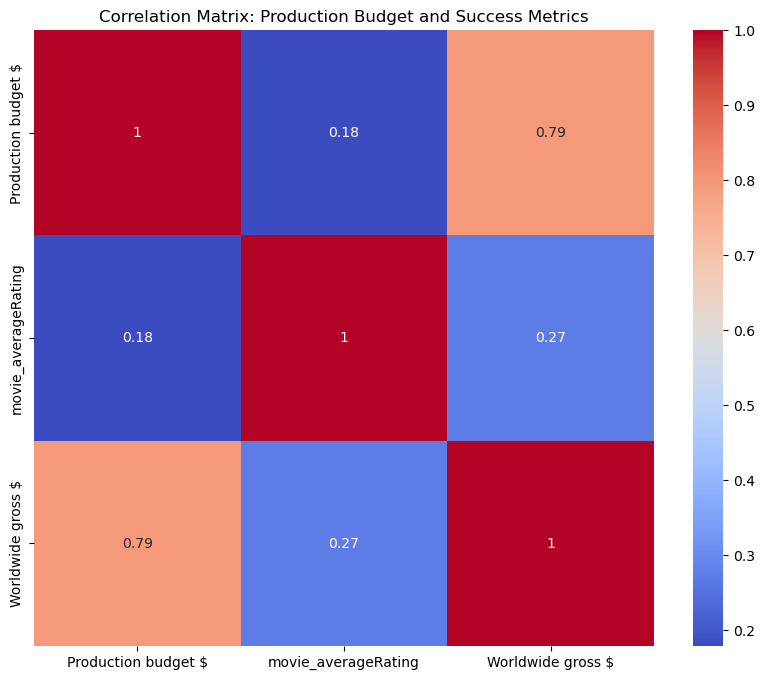

In [135]:
# Correlation matrix between budget, ratings, revenue, and ROI
correlation_matrix = merged_df_cleaned[['Production budget $', 'movie_averageRating', 'Worldwide gross $']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Production Budget and Success Metrics')
plt.show()

> - What to Watch For:
>
>Multicollinearity: Since ROI is calculated using production budget, analyzing their relationship directly could lead to misleading interpretations (e.g., showing high correlations that are simply a by-product of the formula itself).
>
>- How to Adjust:
Focus separately on how production budget affects revenue and ratings without tying it directly to ROI, as this will give more meaningful insights.


> Insights:
> - Revenue is highly dependent on production budget, meaning high-budget films are essential for generating large box-office returns.
>- Movie ratings are not strongly affected by the budget, meaning low-budget films can still perform well with audiences and critics.
>- Critical acclaim (ratings) has a moderate effect on revenue, but it doesn’t directly lead to high Revenue.

2. Simple Linear Regression

We'll test the relationship between production budget and success metrics such as ratings and Worldwide revenue. Quantify how much production budget impacts these metrics.

    2.1 Production budget vs Revenue

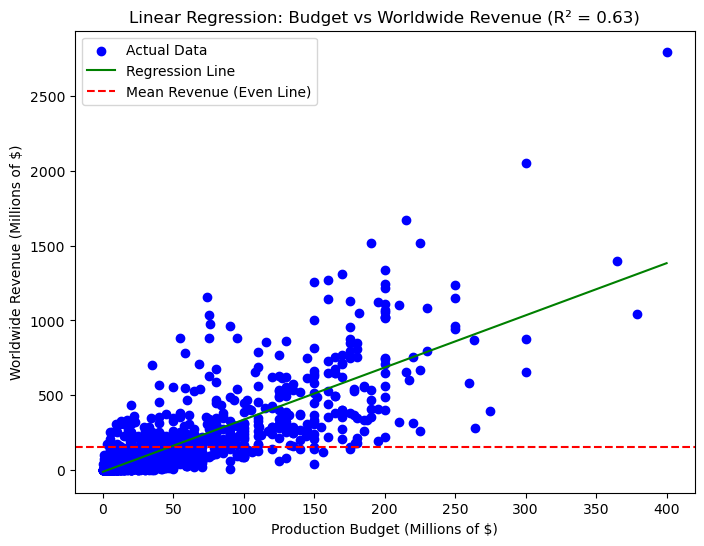

In [150]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Convert the units to millions of dollars
X_budget_millions = merged_df_cleaned[['Production budget $']].dropna() / 1e6
y_revenue_millions = merged_df_cleaned[['Worldwide gross $']].dropna() / 1e6

# Align indices of X and y
X_budget_millions = X_budget_millions.loc[y_revenue_millions.index]
y_revenue_millions = y_revenue_millions.loc[X_budget_millions.index]

# Create and fit the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_budget_millions, y_revenue_millions)

# Predict and calculate R-squared
y_pred_revenue = lin_reg.predict(X_budget_millions)
r_squared_revenue = lin_reg.score(X_budget_millions, y_revenue_millions)

# Calculate the mean of the revenue for the even line
mean_revenue = np.mean(y_revenue_millions)

# Plot regression for budget vs revenue (in millions)
plt.figure(figsize=(8, 6))
plt.scatter(X_budget_millions, y_revenue_millions, color='blue', label='Actual Data')
plt.plot(X_budget_millions, y_pred_revenue, color='green', label='Regression Line')

# Add an "even line" (mean of the dependent variable, i.e., mean revenue)
plt.axhline(y=mean_revenue, color='red', linestyle='--', label='Mean Revenue (Even Line)')

# Customize plot with units in millions
plt.xlabel('Production Budget (Millions of $)')
plt.ylabel('Worldwide Revenue (Millions of $)')
plt.title(f'Linear Regression: Budget vs Worldwide Revenue (R² = {r_squared_revenue:.2f})')
plt.legend()

# Show plot
plt.show()


> Insights : R² = 0.63 for Budget vs Worldwide Revenue, confirming that higher production budgets strongly correlate with increased revenue.

    2.2 Production Budget vs Ratings


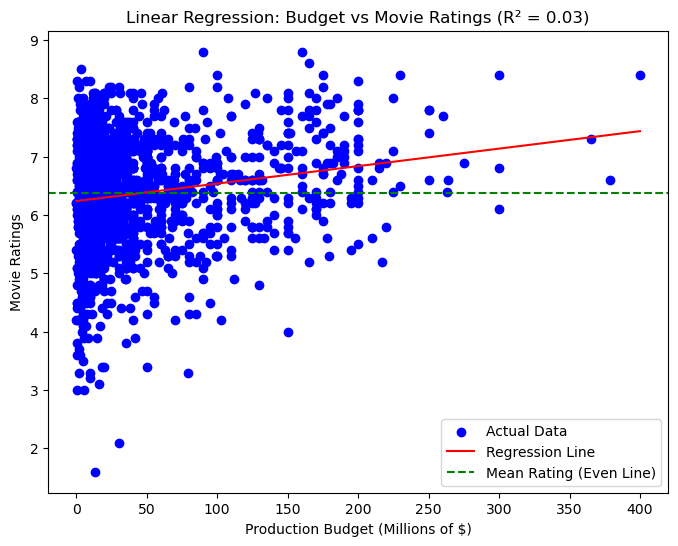

In [211]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
X_budget = merged_df_cleaned[['Production budget $']].dropna() / 1e6  # Convert to millions
y_rating = merged_df_cleaned['movie_averageRating'].dropna()

# Align indices of X and y
X_budget = X_budget.loc[y_rating.index]
y_rating = y_rating.loc[X_budget.index]

# Create and fit the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_budget, y_rating)

# Predict and calculate R-squared
y_pred_rating_budget = lin_reg.predict(X_budget)
r_squared_budget = lin_reg.score(X_budget, y_rating)

# Calculate the mean of the ratings for the even line
mean_rating = np.mean(y_rating)

# Plot the regression results
plt.figure(figsize=(8, 6))
plt.scatter(X_budget, y_rating, color='blue', label='Actual Data')
plt.plot(X_budget, y_pred_rating_budget, color='red', label='Regression Line')

# Add an "even line" (mean of the dependent variable, i.e., mean rating)
plt.axhline(y=mean_rating, color='green', linestyle='--', label='Mean Rating (Even Line)')

# Customize plot with units in millions
plt.xlabel('Production Budget (Millions of $)')
plt.ylabel('Movie Ratings')
plt.title(f'Linear Regression: Budget vs Movie Ratings (R² = {r_squared_budget:.2f})')
plt.legend()

# Show plot
plt.show()


> Insights : 
>- The R² value is 0.03, which means that only about 3% of the variance in movie ratings can be explained by the production budget.
>- This very low R² value suggests that production budget is not a strong predictor of movie ratings. There are likely many other factors that influence movie ratings more significantly.
>- There is a slight positive trend between budget and ratings, but it is not strong. Higher-budget films tend to have slightly higher ratings, but the effect is minimal.

3. Statistical Testing (T-Test) 

To test this statistically, we'll compare movies with high production budgets vs low production budgets and use t-tests to determine whether the differences in ratings, revenue, and ROI are statistically significant.

    3.1 Hypothesis


Hypothesis : Comparing success matrices for High vs Low Budget Movies

- Null Hypothesis (H0): There is no significant difference in average worldwide revenue between short runtime and long runtime movies.

- Alternative Hypothesis (H1): 
There is a significant difference in average worldwide revenue between short runtime and long runtime movies.


    3.2 Statistical Testing

- Step 1: Divide Movies Into Two Groups (High Budget vs Low Budget)

We will split the dataset into two groups based on median production budget:

High budget movies: Movies with a production budget greater than or equal to the median.

Low budget movies: Movies with a production budget below the median.

In [140]:
# Divide into 2 groups based on median production budget
# Calculate the median production budget
median_budget = merged_df_cleaned['Production budget $'].median()

# Create high and low budget groups
high_budget_movies = merged_df_cleaned[merged_df_cleaned['Production budget $'] >= median_budget]
low_budget_movies = merged_df_cleaned[merged_df_cleaned['Production budget $'] < median_budget]

# Check group sizes
print(f"High budget movies: {len(high_budget_movies)}, Low budget movies: {len(low_budget_movies)}")


High budget movies: 738, Low budget movies: 672


- Step 2: Perform T-Test on Ratings

We will compare the average movie ratings of high-budget vs low-budget movies using a t-test.

In [141]:
from scipy import stats

# Perform t-test for ratings
t_stat_rating, p_val_rating = stats.ttest_ind(high_budget_movies['movie_averageRating'], low_budget_movies['movie_averageRating'], nan_policy='omit')

# Print the t-test result for ratings
print(f"T-test for Ratings - p-value: {p_val_rating}")


T-test for Ratings - p-value: 0.0006007288176704499


> Insights : If the p-value is less than 0.05, it means there is a statistically significant difference in ratings between high-budget and low-budget movies.

- Step 3: Perform T-Test on Worldwide Revenue

We will compare the average worldwide revenue of high-budget vs low-budget movies using a t-test.

In [142]:
# Perform t-test for worldwide revenue
t_stat_revenue, p_val_revenue = stats.ttest_ind(high_budget_movies['Worldwide gross $'], low_budget_movies['Worldwide gross $'], nan_policy='omit')

# Print the t-test result for revenue
print(f"T-test for Worldwide Revenue - p-value: {p_val_revenue}")


T-test for Worldwide Revenue - p-value: 5.85585510746422e-67


> Insights : If the p-value is less than 0.05, it means there is a statistically significant difference in revenue between high-budget and low-budget movies.

- Step 4: Perform T-Test on ROI

Finally, we will compare the average ROI of high-budget vs low-budget movies using a t-test.

In [143]:
# Perform t-test for ROI
t_stat_roi, p_val_roi = stats.ttest_ind(high_budget_movies['ROI'], low_budget_movies['ROI'], nan_policy='omit')

# Print the t-test result for ROI
print(f"T-test for ROI - p-value: {p_val_roi}")


T-test for ROI - p-value: 0.000327677440997815


> Insights : If the p-value is less than 0.05, it means there is a statistically significant difference in ROI between high-budget and low-budget movies.

## Extra Analysis

### Director Related

1. Top 10 Directors by Popularity (Votes)

/var/folders/tc/1ms7n2d57vv5dn_343mwj34r0000gn/T/ipykernel_26456/1293978244.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_directors_by_votes['primary_name'], y=top_directors_by_votes['total_votes_millions'], palette='magma')


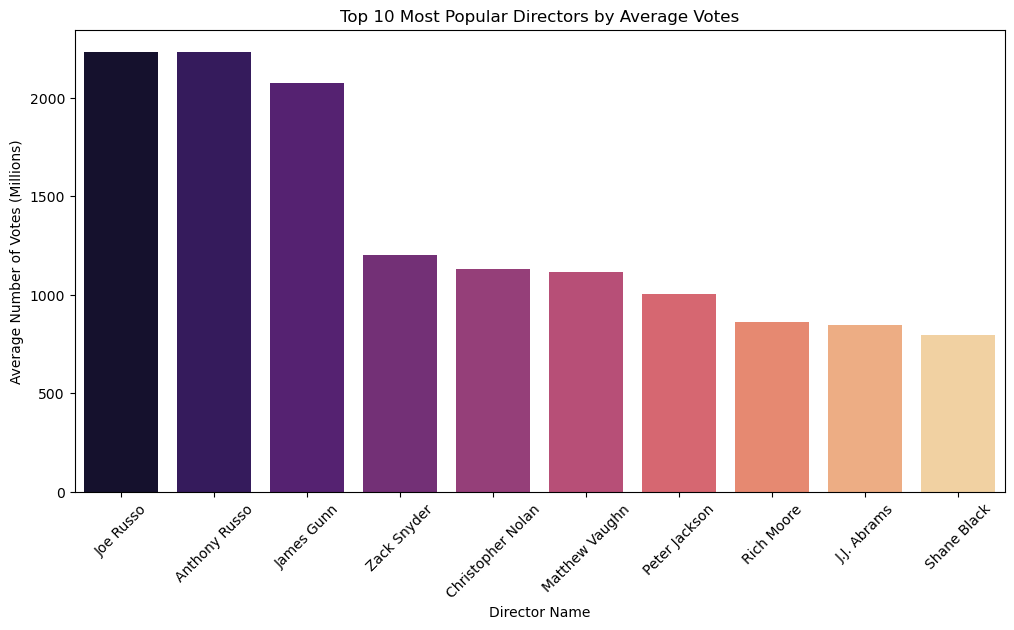

In [212]:
# Convert total_votes to millions
top_directors_by_votes['total_votes_millions'] = top_directors_by_votes['total_votes'] / 1_000_000

# Visualization for top 10 directors by average number of votes in millions
plt.figure(figsize=(12, 6))
sns.barplot(x=top_directors_by_votes['primary_name'], y=top_directors_by_votes['total_votes_millions'], palette='magma')
plt.xticks(rotation=45)
plt.title('Top 10 Most Popular Directors by Average Votes')
plt.xlabel('Director Name')
plt.ylabel('Average Number of Votes (Millions)')
plt.show()


2. Top Directors by ROI

In [103]:
# Group by directors and calculate average ROI and movie count
director_profitability = merged_df_cleaned.groupby('director_name').agg(
    avg_roi=('ROI', 'mean'),
    avg_revenue=('Worldwide gross $', 'mean'),
    movie_count=('movie_title', 'count')
).reset_index()

# Filter for directors with more than one movie
director_profitability_filtered = director_profitability[director_profitability['movie_count'] > 1]

# Sort the directors by ROI in descending order to find the most profitable ones
most_profitable_director = director_profitability_filtered.sort_values(by='avg_roi', ascending=False).head()

# Display the most profitable director
print(most_profitable_director[['director_name', 'avg_roi', 'avg_revenue', 'movie_count']])


          director_name    avg_roi  avg_revenue  movie_count
838  William Brent Bell  53.290793   84990221.0            2
405        Jordan Peele  30.630308  254160056.0            2
68        Barry Jenkins  21.534472   43163495.0            2
19        Alex Kendrick  20.251844   54835310.0            2
383    John R. Leonetti  19.736494  140167436.0            2


3. Q: How directors' experiences affect the movie success metrics?

3.1 Group by director to calculate:
- Director experience: The number of movies each director has directed.
- Average rating, average worldwide revenue, and average ROI for each director.

In [170]:
# Group by directors to calculate number of movies directed (experience), and success metrics
director_success = merged_df_cleaned.groupby('director_name').agg(
    num_movies_directed=('movie_title', 'count'),  # Number of movies directed
    avg_rating=('movie_averageRating', 'mean'),   # Average movie rating
    avg_revenue=('Worldwide gross $', 'mean'),    # Average worldwide revenue
    avg_roi=('ROI', 'mean')                     # Average ROI
          
).reset_index()

# Display the calculated data for directors
print(director_success.head())


          director_name  num_movies_directed  avg_rating   avg_revenue  \
0                     -                  114    6.533333  2.906370e+08   
1  Abderrahmane Sissako                    1    7.100000  6.815821e+06   
2            Adam McKay                    4    6.975000  1.368098e+08   
3          Adam Robitel                    2    6.050000  1.642138e+08   
4            Adam Salky                    1    6.200000  6.337300e+04   

     avg_roi  
0   7.124439  
1   1.726328  
2   1.772916  
3  16.285917  
4  -0.841568  


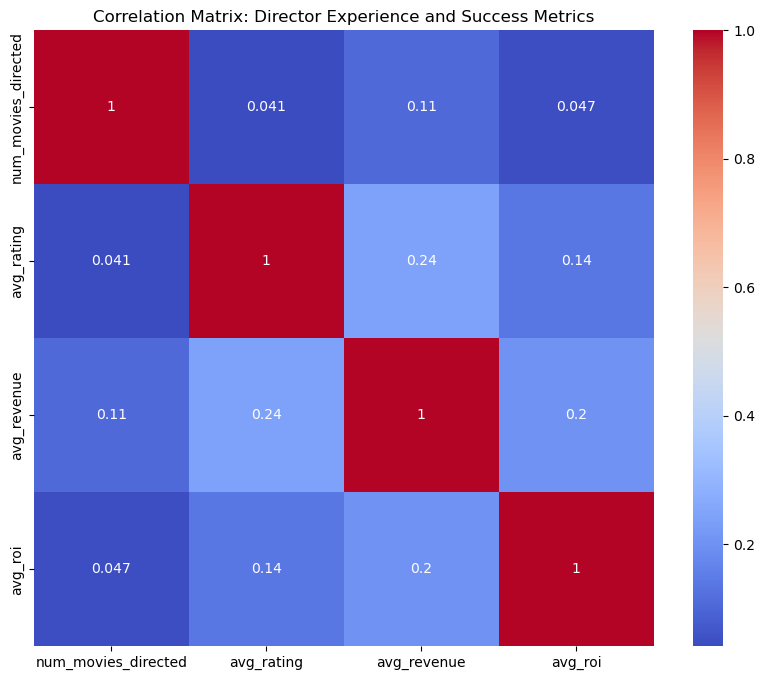

In [171]:
# Perform correlation analysis between director experience and success metrics
director_corr_matrix = director_success[['num_movies_directed', 'avg_rating', 'avg_revenue', 'avg_roi']].corr()

# Visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(director_corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Director Experience and Success Metrics')
plt.show()


> Insights : 
>- Director experience does not have a strong impact on ratings or ROI. This implies that even less experienced directors can achieve successful outcomes in terms of profitability, especially for lower-budget films.
>- There is a moderate correlation between ratings and revenue, indicating that better-rated movies tend to perform better financially, but this relationship is not very strong.

### Genres Related

1. Top Genres by Average Runtime 

In [117]:
# Explode the genres column since some movies have multiple genres
merged_df_exploded = merged_df_cleaned.assign(genres=merged_df_cleaned['genres_x'].str.split(',')).explode('genres_x')

# Group by genres and calculate the average runtime for each genre
average_runtime_by_genre = merged_df_exploded.groupby('genres_x')['runtime_minutes_x'].mean().reset_index()

# Sort by runtime
average_runtime_by_genre = average_runtime_by_genre.sort_values(by='runtime_minutes_x', ascending=False)

# Display the top genres with the longest runtimes
print(average_runtime_by_genre.head(10))


     genres_x  runtime_minutes_x
8     Fantasy         118.833333
3   Biography         118.354839
0      Action         113.373626
5       Crime         113.366667
7       Drama         111.779661
12    Mystery         111.000000
13    Romance         106.000000
11    Musical         105.000000
14     Sci-Fi         105.000000
4      Comedy         103.082759


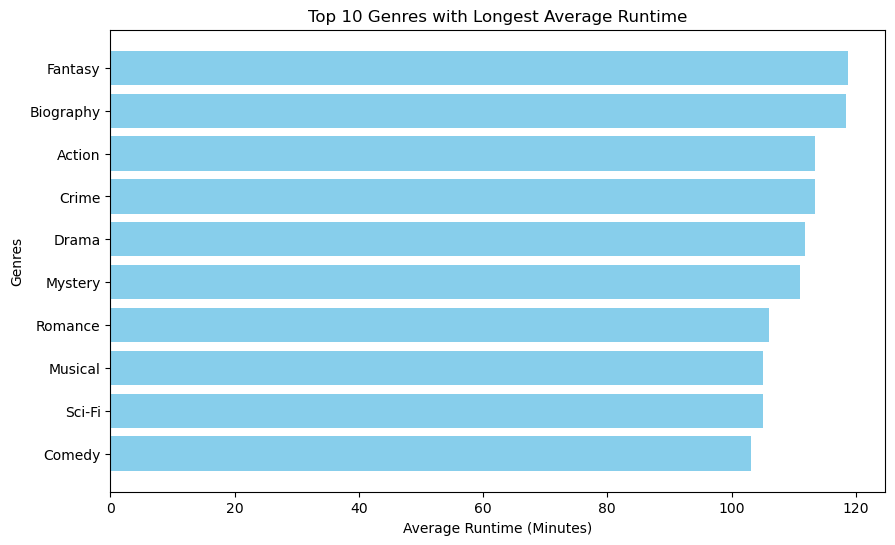

In [118]:
import matplotlib.pyplot as plt

# Plot the top 10 genres by average runtime
plt.figure(figsize=(10, 6))
plt.barh(average_runtime_by_genre['genres_x'].head(10), average_runtime_by_genre['runtime_minutes_x'].head(10), color='skyblue')
plt.xlabel('Average Runtime (Minutes)')
plt.ylabel('Genres')
plt.title('Top 10 Genres with Longest Average Runtime')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


2. Top Genre by Ratings and Revenue

- We’ll first analyze which genres perform best in terms of average ratings and worldwide gross revenue.

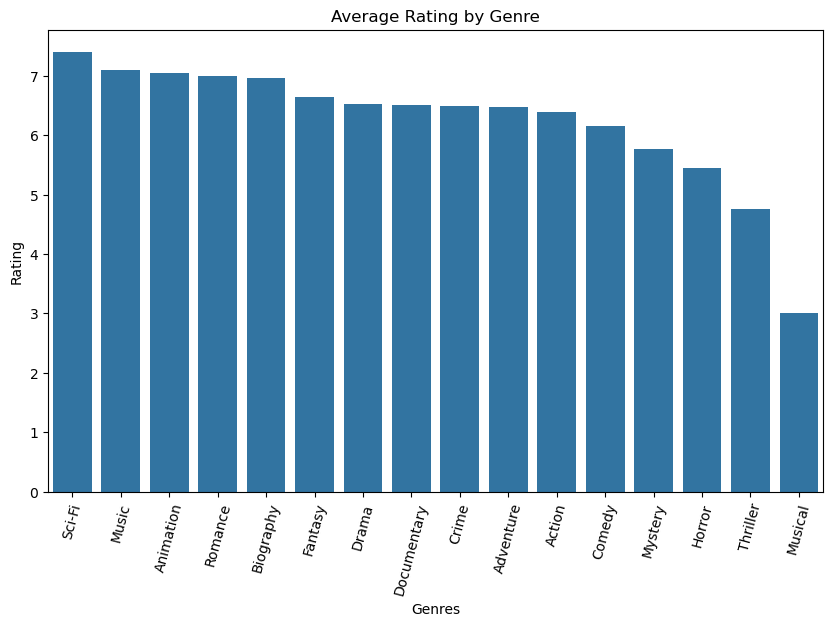

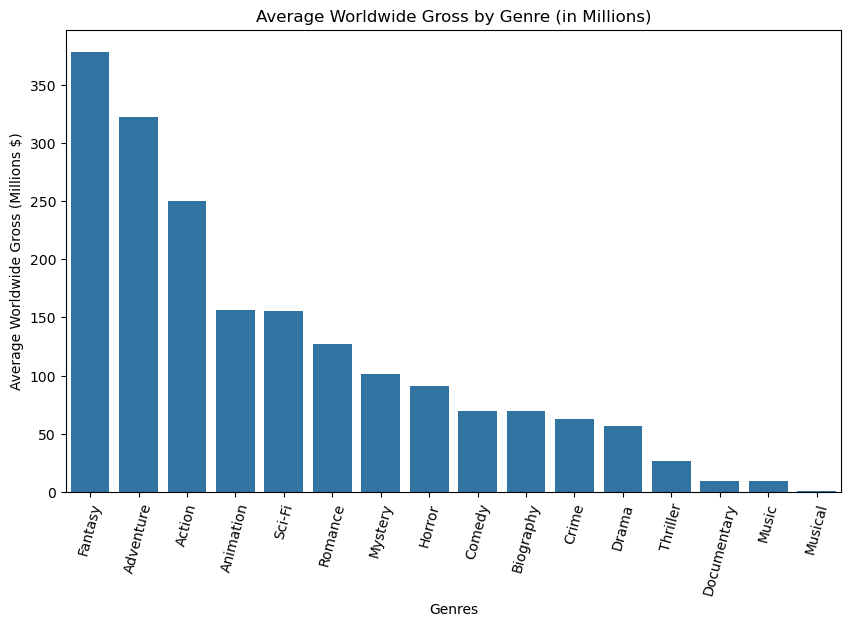

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by genre and calculate average ratings and revenue
# Ensure the correct dataframe is used for the analysis
genre_analysis = merged_df_cleaned.groupby('genres_x').agg(
    avg_rating=('movie_averageRating', 'mean'),
    avg_worldwide_gross=('Worldwide gross $', 'mean')
).reset_index()

# Visualize the top genres by average rating
plt.figure(figsize=(10, 6))
sns.barplot(x='genres_x', y='avg_rating', data=genre_analysis.sort_values(by='avg_rating', ascending=False))
plt.xticks(rotation=75)
plt.xlabel('Genres')
plt.ylabel('Rating')
plt.title('Average Rating by Genre')
plt.show()

# Visualize the top genres by average worldwide gross (in millions)
plt.figure(figsize=(10, 6))
sns.barplot(x='genres_x', y='avg_worldwide_gross', data=genre_analysis.sort_values(by='avg_worldwide_gross', ascending=False))
plt.xticks(rotation=75)
plt.title('Average Worldwide Gross by Genre (in Millions)')
plt.xlabel('Genres')
plt.ylabel('Average Worldwide Gross (Millions $)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1e6))))
plt.show()


>Insights: 
>1. Average Rating by Genre:
>- The Sci-Fi genre stands out with the highest average rating, exceeding 7. Other high-rated genres include Music, Animation, and Romance, with all scoring above 6.8. On the lower end, genres such as Thriller and Musical tend to receive lower ratings, with Musical having the lowest average rating of just over 4.
>- Insight: Audiences tend to rate Sci-Fi, Music, and Animation films more favorably, while genres like Thriller and Musical are rated lower on average.
>2. Average Worldwide Gross by Genre:
>- The chart shows that Fantasy, Adventure, and Action are the top-grossing genres, with Fantasy generating an average worldwide gross of over $350 million. On the other hand, genres such as Thriller, Documentary, and Music are at the bottom of the chart, making significantly less revenue.
>- Insight: High-budget blockbuster genres like Fantasy, Adventure, and Action tend to generate higher worldwide gross revenue, while niche or less commercial genres like Music and Documentary do not perform as well financially.This analysis will help us determine which genres have the best audience reception (through ratings) and which genres generate the highest revenue.

3. ANOVA: Is there any difference in movie ratings across genres?

In [155]:
from scipy import stats

# Perform ANOVA test on ratings by genre
anova_genre_ratings = stats.f_oneway(*[merged_df_cleaned[merged_df_cleaned['genres_x'] == genre]['movie_averageRating'].dropna() for genre in merged_df_cleaned['genres_x'].unique()])

print(f"ANOVA p-value for Genre and Movie Ratings: {anova_genre_ratings.pvalue}")

# Interpretation:
if anova_genre_ratings.pvalue < 0.05:
    print("There is a statistically significant difference in movie ratings across genres.")
else:
    print("No significant difference in movie ratings across genres.")


ANOVA p-value for Genre and Movie Ratings: 7.862208334549084e-28
There is a statistically significant difference in movie ratings across genres.


4. Optimal Budget, Runtime by Genre

In [208]:
# First, we split the 'genres' column into individual genres for proper grouping
# Assuming the genres column is a comma-separated string, we'll first 'explode' it

# Exploding the genres column to separate multiple genres into individual rows
exploded_df = merged_df_cleaned.assign(genres=merged_df_cleaned['genres_x'].str.split(',')).explode('genres_x')

# Group the data by genre and calculate the average budget and runtime
genre_budget_runtime = exploded_df.groupby('genres_x').agg({
    'Production budget $': 'mean',  # Average budget by genre
    'runtime_minutes_x': 'mean'     # Average runtime by genre
}).reset_index()

# Rename columns for clarity
genre_budget_runtime.columns = ['Genre', 'Average Production Budget ($)', 'Average Runtime (Minutes)']

# Display the result
print(genre_budget_runtime)


          Genre  Average Production Budget ($)  Average Runtime (Minutes)
0        Action                   8.116473e+07                 113.373626
1     Adventure                   8.493229e+07                 101.923611
2     Animation                   2.740000e+07                  93.200000
3     Biography                   2.348871e+07                 118.354839
4        Comedy                   2.337197e+07                 103.082759
5         Crime                   2.492450e+07                 113.366667
6   Documentary                   3.945938e+06                  94.875000
7         Drama                   1.885478e+07                 111.779661
8       Fantasy                   8.966667e+07                 118.833333
9        Horror                   1.161308e+07                  95.184615
10        Music                   1.800000e+07                  93.000000
11      Musical                   5.600000e+06                 105.000000
12      Mystery                   2.90

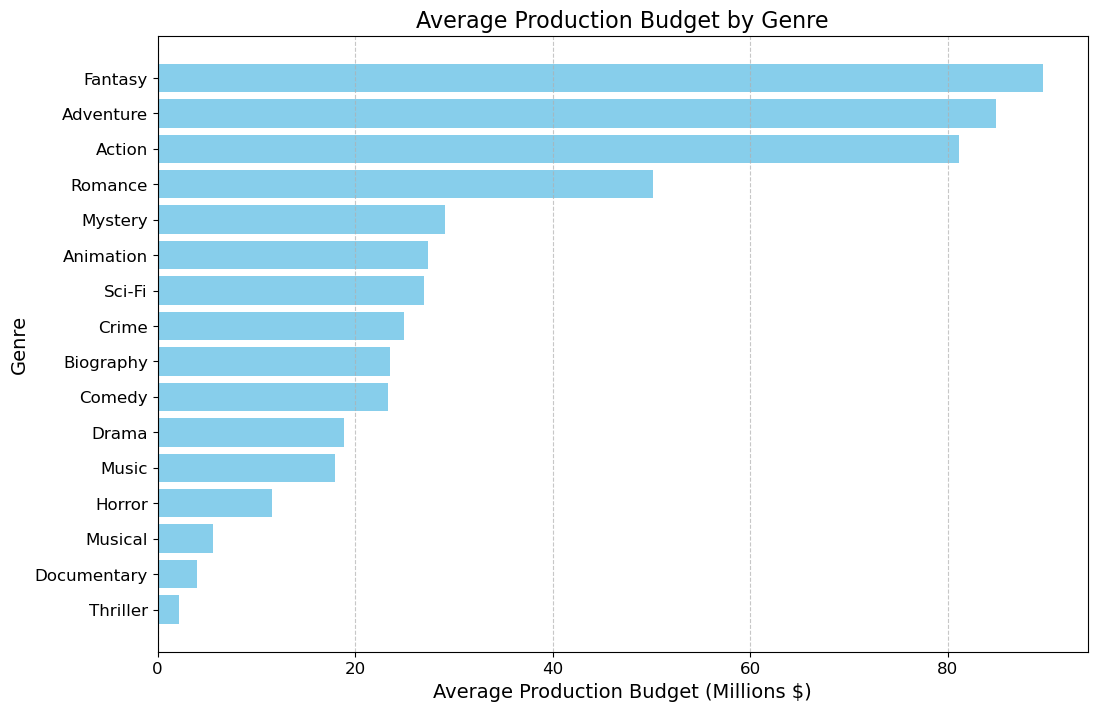

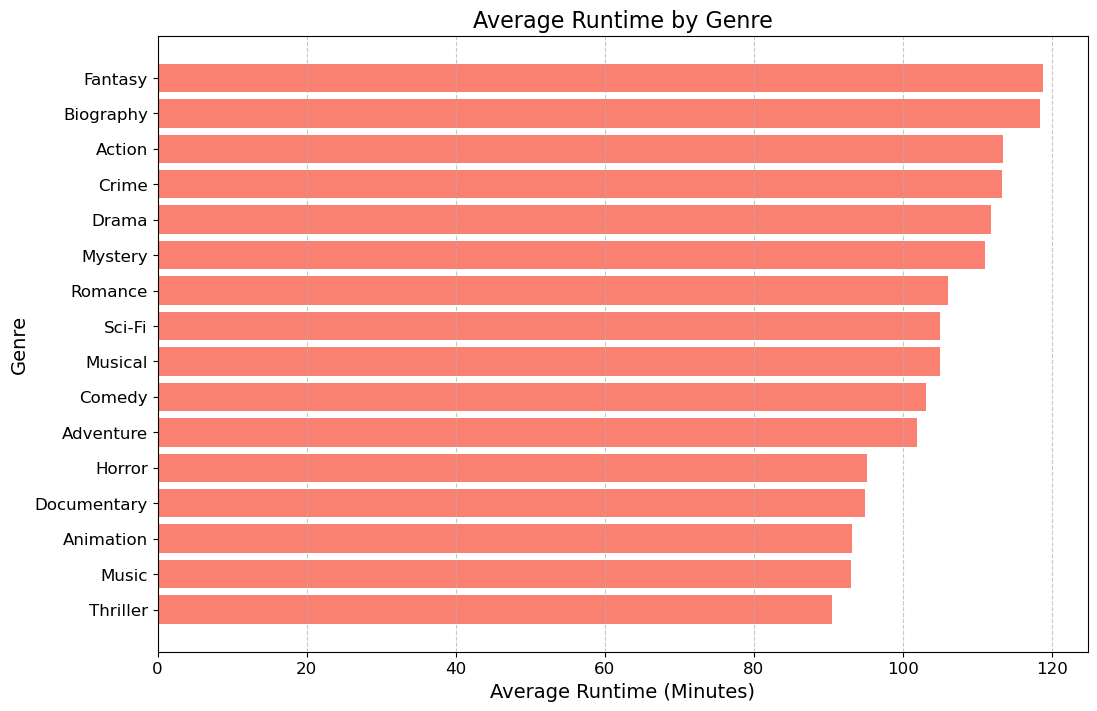

In [209]:
import matplotlib.pyplot as plt

# Convert the units to millions
genre_budget_runtime['Average Production Budget ($)'] /= 1e6

plt.figure(figsize=(12, 8))
genre_budget_runtime_sorted_asc = genre_budget_runtime.sort_values(by='Average Production Budget ($)', ascending=True)
plt.barh(genre_budget_runtime_sorted_asc['Genre'], genre_budget_runtime_sorted_asc['Average Production Budget ($)'], color='skyblue')
plt.xlabel('Average Production Budget (Millions $)', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.title('Average Production Budget by Genre', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Plotting average runtime by genre in ascending order
plt.figure(figsize=(12, 8))
genre_runtime_sorted_asc = genre_budget_runtime.sort_values(by='Average Runtime (Minutes)', ascending=True)
plt.barh(genre_runtime_sorted_asc['Genre'], genre_runtime_sorted_asc['Average Runtime (Minutes)'], color='salmon')
plt.xlabel('Average Runtime (Minutes)', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.title('Average Runtime by Genre', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



> Analysis of the Two Plots
> 1. Average Production Budget by Genre:
>- Insight:
The genres with the highest production budgets are Fantasy, Adventure, and Action, with average production budgets reaching above $80 million.
On the other hand, genres like Horror, Musical, and Documentary have the lowest average budgets, ranging from $10 to $15 million.
>
>- Implication:
High-budget genres such as Fantasy and Adventure often involve expensive special effects and larger-scale productions, which justifies the higher production costs.
Meanwhile, Horror and Documentary films tend to be more low-budget and lean on storytelling rather than extensive production, allowing them to remain profitable despite lower investments.
>
> 2. Average Runtime by Genre:
>- Insight:
Fantasy, Biography, and Action movies have the longest average runtimes, often exceeding 120 minutes.
Conversely, Thriller, Music, and Documentary genres tend to have shorter runtimes, with the average runtime falling around 80-90 minutes.
>
>- Implication:
Longer runtimes for Fantasy and Biography films could be linked to more elaborate narratives and character development, which often require extended screen time to fully unfold.
Shorter runtimes for Thriller and Horror movies are often by design, as these genres aim for fast-paced, tension-building experiences that work well within a shorter timeframe.

5. Find the Ideal Budget Range per Genre

In [193]:
# Exploding the genres column to separate multiple genres into individual rows
exploded_df = merged_df_cleaned.assign(genres=merged_df_cleaned['genres_x'].str.split(',')).explode('genres_x')

# Convert the budget units to millions
exploded_df['Production budget $'] = exploded_df['Production budget $'] / 1e6

# Group by genre and calculate the median, 25th percentile, and 75th percentile for production budgets
genre_budget_stats = exploded_df.groupby('genres_x').agg({
    'Production budget $': ['median', 'quantile']
}).reset_index()

# Apply custom quantile function for 25th and 75th percentiles
genre_budget_stats['25th Percentile'] = exploded_df.groupby('genres_x')['Production budget $'].quantile(0.25).values
genre_budget_stats['75th Percentile'] = exploded_df.groupby('genres_x')['Production budget $'].quantile(0.75).values

# Rename columns for clarity
genre_budget_stats.columns = ['Genre', 'Median Budget ($M)', 'Quantile', '25th Percentile Budget ($M)', '75th Percentile Budget ($M)']

# Display the result
print(genre_budget_stats)


          Genre  Median Budget ($M)  Quantile  25th Percentile Budget ($M)  \
0        Action               58.00     58.00                       30.000   
1     Adventure               75.50     75.50                       29.500   
2     Animation                9.00      9.00                        8.500   
3     Biography               19.55     19.55                       10.000   
4        Comedy               18.50     18.50                        8.000   
5         Crime               21.00     21.00                        8.875   
6   Documentary                2.00      2.00                        0.500   
7         Drama               12.00     12.00                        4.000   
8       Fantasy               33.50     33.50                       17.500   
9        Horror                5.50      5.50                        3.500   
10        Music               18.00     18.00                       18.000   
11      Musical                5.60      5.60                   

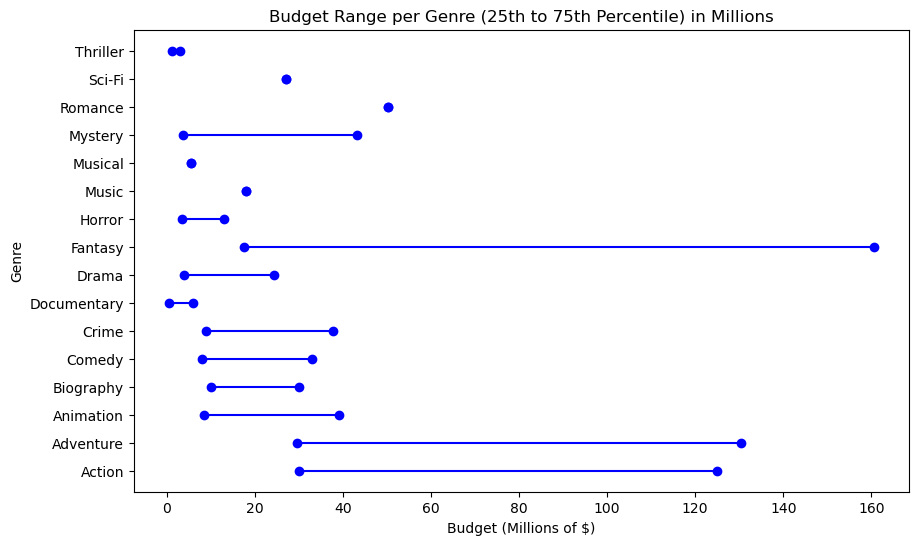

In [196]:
import matplotlib.pyplot as plt

# Plot the budget range for each genre (25th to 75th percentile) in millions
plt.figure(figsize=(10, 6))
for index, row in genre_budget_stats.iterrows():
    plt.plot([row['25th Percentile Budget ($M)'], row['75th Percentile Budget ($M)']], [row['Genre'], row['Genre']], marker='o', color='blue')

plt.xlabel('Budget (Millions of $)')
plt.ylabel('Genre')
plt.title('Budget Range per Genre (25th to 75th Percentile) in Millions')
plt.show()


> Analysis of Budget Range per Genre (25th to 75th Percentile)
>
> Insight:
>- The chart shows the distribution of movie budgets across different genres, focusing on the interquartile range (25th to 75th percentile).
>- Fantasy and Action films have the widest budget ranges, with Fantasy budgets extending up to nearly $160 million, and Action films typically ranging from $50 million to $125 million.
>- On the lower end, Thriller, Horror, and Documentary genres exhibit relatively narrow budget ranges, often falling between $10 million and $30 million.
>
> Implication:
>- High-budget genres like Fantasy and Action are prone to significant investment due to their visual and technical demands, such as special effects, large-scale production, and star-studded casts.
>- On the other hand, genres like Thriller and Horror can be produced effectively within smaller budget ranges, suggesting a lower financial risk for producers while still having the potential for high returns, especially in genres like Horror, where smaller budgets are common.

### Runtime related

1. Runtime vs Success Metrics Correlation

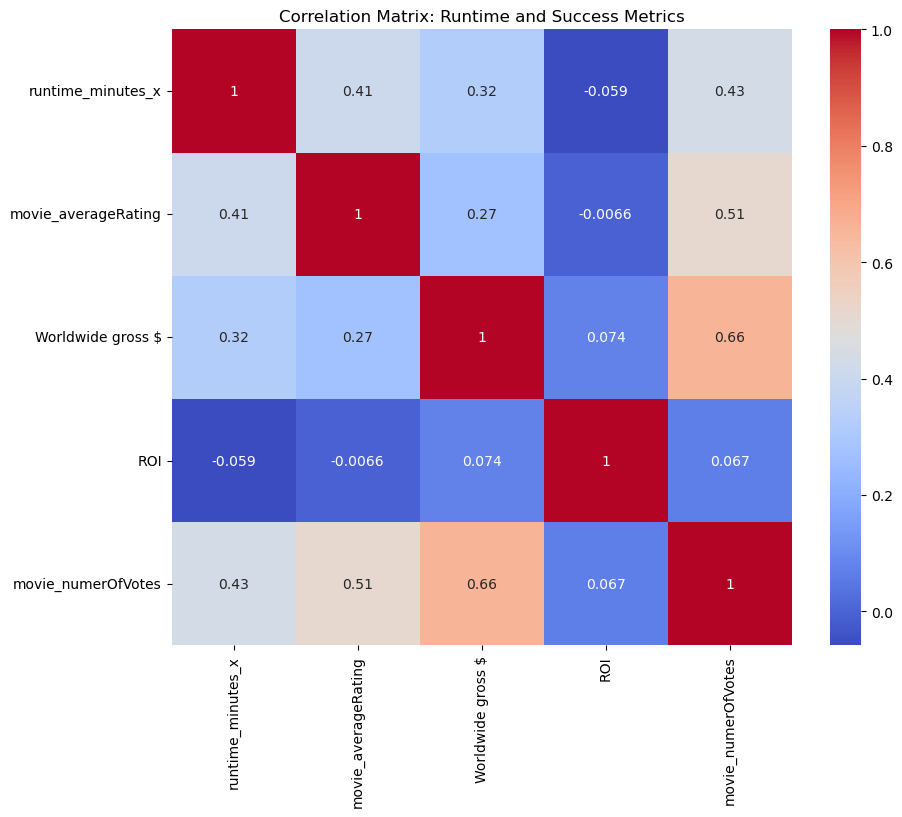

In [164]:
# Perform correlation analysis between runtime and success metrics
correlation_runtime_df = merged_df_cleaned[['runtime_minutes_x', 'movie_averageRating', 'Worldwide gross $', 'ROI', 'movie_numerOfVotes']].dropna()
correlation_runtime_matrix = correlation_runtime_df.corr()

# Visualize the correlation matrix
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_runtime_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Runtime and Success Metrics')
plt.show()


> Key Observations:
>
>1. Runtime vs Average Rating (0.41):
>- There is a moderate positive correlation between a movie's runtime and its average rating. This suggests that longer movies tend to receive slightly higher ratings, but the relationship is not extremely strong.
>2. Runtime vs Worldwide Gross Revenue (0.32):
>- A moderate positive correlation also exists between runtime and worldwide gross revenue. This indicates that longer movies tend to generate more revenue, likely due to their larger scale and higher production value. However, the correlation is not strong enough to imply causation.
>3. Runtime vs ROI (-0.059):
>- There is a weak negative correlation between runtime and ROI. This implies that longer movies are not necessarily more profitable in terms of return on investment, meaning high-budget or long movies might not always deliver proportional returns compared to their production costs.
>4. Runtime vs Number of Votes (0.43):
>- There is a moderate positive correlation between runtime and the number of votes (engagement). This suggests that longer movies tend to have more audience engagement, potentially indicating that audiences are more involved with films that have longer runtimes.
>5. Worldwide Gross Revenue vs Number of Votes (0.66):
>- There is a strong positive correlation between worldwide gross revenue and the number of votes. Movies that make more money tend to have more audience engagement, as more viewers are exposed to them and more people vote for them.
>6. ROI vs Other Metrics:
>- Interestingly, ROI has weak correlations with all other variables, especially runtime (-0.059), meaning that profitability (in terms of ROI) doesn’t strongly depend on runtime, ratings, or revenue. ROI seems to be more variable, depending on factors outside the typical success metrics.

2. T-Test: Comparing Success Metrics for Short vs Long Runtime Movies

We’ll compare movies with runtime shorter than Median and those with runtime of Median or more to see if there’s a significant difference in revenue or Ratings or ROI.

    2.1 Hypothesis: 

- Null Hypothesis (H0):
The mean Success Metrics of short runtime movies is equal to the mean Success Metrics of long runtime movies.​	
 
- Alternative Hypothesis (H1) :
The mean Success Metrics of short runtime movies is not equal to the mean Success Metrics of long runtime movies.

In [162]:
from scipy import stats

# Split movies into short and long runtime categories
median_runtime = merged_df_cleaned['runtime_minutes_x'].median()
short_runtime = merged_df_cleaned[merged_df_cleaned['runtime_minutes_x'] <= median_runtime]
long_runtime = merged_df_cleaned[merged_df_cleaned['runtime_minutes_x'] > median_runtime]

# What is median of runtime_minutes_x?
print(f"Median Runtime: {median_runtime}")

# Perform T-test for revenue, ratings, and ROI
t_stat_revenue, p_val_revenue = stats.ttest_ind(short_runtime['Worldwide gross $'], long_runtime['Worldwide gross $'])
t_stat_ratings, p_val_ratings = stats.ttest_ind(short_runtime['movie_averageRating'], long_runtime['movie_averageRating'])
t_stat_roi, p_val_roi = stats.ttest_ind(short_runtime['ROI'], long_runtime['ROI'])

print(f"T-test p-value for Revenue: {p_val_revenue}")
print(f"T-test p-value for Ratings: {p_val_ratings}")
print(f"T-test p-value for ROI: {p_val_roi}")


Median Runtime: 106.0
T-test p-value for Revenue: 1.0188061156059812e-11
T-test p-value for Ratings: 2.3476649512190665e-34
T-test p-value for ROI: 0.0783134279777394


>Insights : 
>- If the p-value for any of these tests is less than 0.05, you would reject the null hypothesis and conclude that there is a statistically significant difference between short and long runtime movies for that metric (revenue, ratings, or ROI).
>- If the p-value is greater than 0.05, you would fail to reject the null hypothesis, meaning there’s no significant difference in that metric between short and long runtime movies.
>- Your T-test p-values already suggest that runtime significantly impacts revenue and ratings but has no significant impact on ROI.

    2.2 Which Runtime has more on revenue, ratings, roi?

In [176]:
# Calculate average revenue, ratings, and ROI for short runtime movies
average_revenue_short_runtime = short_runtime['Worldwide gross $'].mean()
average_rating_short_runtime = short_runtime['movie_averageRating'].mean()
average_roi_short_runtime = short_runtime['ROI'].mean()

# Calculate average revenue, ratings, and ROI for long runtime movies
average_revenue_long_runtime = long_runtime['Worldwide gross $'].mean()
average_rating_long_runtime = long_runtime['movie_averageRating'].mean()
average_roi_long_runtime = long_runtime['ROI'].mean()

# Print the results for comparison
print(f"Average Revenue for Short Runtime Movies: {average_revenue_short_runtime}")
print(f"Average Ratings for Short Runtime Movies: {average_rating_short_runtime}")
print(f"Average ROI for Short Runtime Movies: {average_roi_short_runtime}")

print(f"Average Revenue for Long Runtime Movies: {average_revenue_long_runtime}")
print(f"Average Ratings for Long Runtime Movies: {average_rating_long_runtime}")
print(f"Average ROI for Long Runtime Movies: {average_roi_long_runtime}")


Average Revenue for Short Runtime Movies: 108961710.79295775
Average Ratings for Short Runtime Movies: 6.082957746478873
Average ROI for Short Runtime Movies: 3.6642694279756323
Average Revenue for Long Runtime Movies: 198146312.81285715
Average Ratings for Long Runtime Movies: 6.683142857142857
Average ROI for Long Runtime Movies: 2.487610489533165


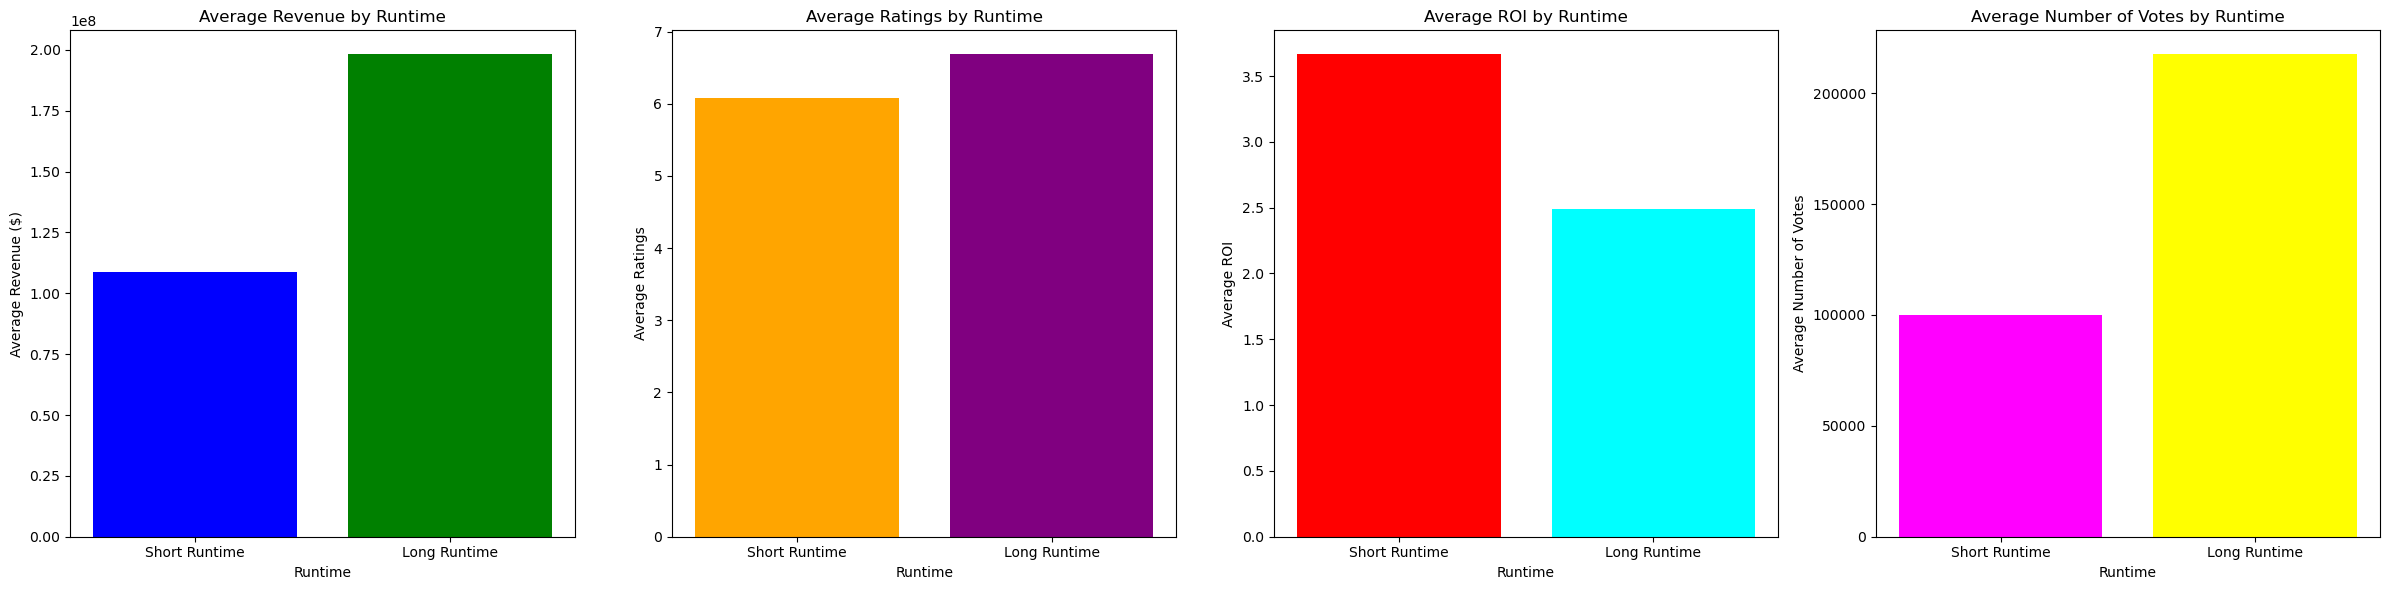

In [210]:
import matplotlib.pyplot as plt

# Data for plotting
categories = ['Short Runtime', 'Long Runtime']
average_revenues = [average_revenue_short_runtime, average_revenue_long_runtime]
average_ratings = [average_rating_short_runtime, average_rating_long_runtime]
average_rois = [average_roi_short_runtime, average_roi_long_runtime]
average_votes = [short_runtime['movie_numerOfVotes'].mean(), long_runtime['movie_numerOfVotes'].mean()]

# Create a figure and axis
fig, ax = plt.subplots(1, 4, figsize=(24, 6))

# Bar chart for average revenue
ax[0].bar(categories, average_revenues, color=['blue', 'green'])
ax[0].set_title('Average Revenue by Runtime')
ax[0].set_ylabel('Average Revenue ($)')
ax[0].set_xlabel('Runtime')

# Bar chart for average ratings
ax[1].bar(categories, average_ratings, color=['orange', 'purple'])
ax[1].set_title('Average Ratings by Runtime')
ax[1].set_ylabel('Average Ratings')
ax[1].set_xlabel('Runtime')

# Bar chart for average ROI
ax[2].bar(categories, average_rois, color=['red', 'cyan'])
ax[2].set_title('Average ROI by Runtime')
ax[2].set_ylabel('Average ROI')
ax[2].set_xlabel('Runtime')

# Bar chart for average number of votes
ax[3].bar(categories, average_votes, color=['magenta', 'yellow'])
ax[3].set_title('Average Number of Votes by Runtime')
ax[3].set_ylabel('Average Number of Votes')
ax[3].set_xlabel('Runtime')

# Display the charts
plt.tight_layout()
plt.show()


>Insights: Long runtime films tend to be more successful in terms of revenue, audience engagement, and slightly higher ratings, but short runtime films offer a more favorable ROI. 

3. Runtime vs Success  Metrics Simple Linear Regression

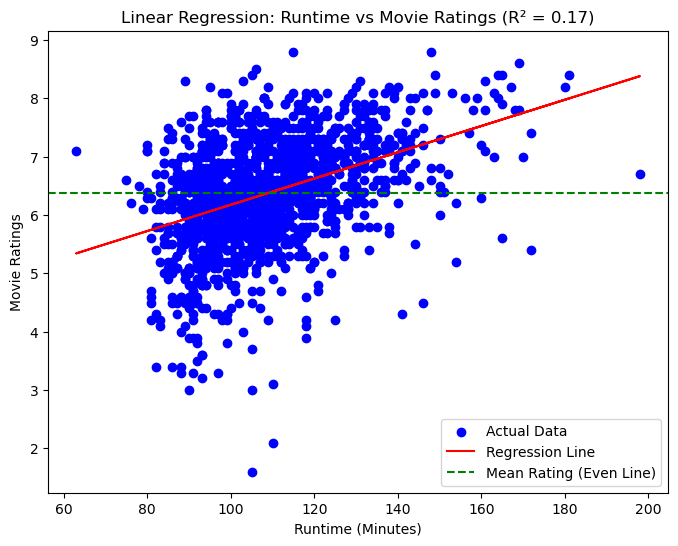

In [173]:
# Prepare data
X_runtime = merged_df_cleaned[['runtime_minutes_x']].dropna()
y_rating_runtime = merged_df_cleaned['movie_averageRating'].dropna()

# Align indices of X and y
X_runtime = X_runtime.loc[y_rating_runtime.index]
y_rating_runtime = y_rating_runtime.loc[X_runtime.index]

# Create and fit the linear regression model
lin_reg.fit(X_runtime, y_rating_runtime)

# Predict and calculate R-squared
y_pred_runtime = lin_reg.predict(X_runtime)
r_squared_runtime = lin_reg.score(X_runtime, y_rating_runtime)

# Calculate the mean of the ratings for the even line
mean_rating = y_rating_runtime.mean()

# Plot the regression results
plt.figure(figsize=(8, 6))
plt.scatter(X_runtime, y_rating_runtime, color='blue', label='Actual Data')
plt.plot(X_runtime, y_pred_runtime, color='red', label='Regression Line')

# Add an "even line" (mean of the dependent variable, i.e., mean rating)
plt.axhline(y=mean_rating, color='green', linestyle='--', label='Mean Rating (Even Line)')

plt.xlabel('Runtime (Minutes)')
plt.ylabel('Movie Ratings')
plt.title(f'Linear Regression: Runtime vs Movie Ratings (R² = {r_squared_runtime:.2f})')
plt.legend()
plt.show()


> This linear regression plot illustrates the relationship between runtime (in minutes) and movie ratings. Here's the interpretation of the graph:
>
> 1. Regression Line:
> The red line represents the linear regression line, indicating a positive correlation between runtime and movie ratings. As the runtime increases, there tends to be a slight increase in the movie ratings, showing that longer movies tend to receive higher ratings.
> 2. R² Value:
> The R² value of 0.17 suggests that 17% of the variance in movie ratings can be explained by the runtime. While the relationship is positive, the R² is relatively low, indicating that runtime alone does not strongly predict movie ratings. Other factors likely play a more significant role in determining ratings.
> 3. Mean Rating (Even Line):
> The green dashed line represents the mean rating of the dataset, which is around 6.5. The regression line shows that movies with runtimes longer than the mean (~120 minutes) tend to have ratings above the mean, while shorter movies generally fall closer to the mean rating.
>
> Insight: Although there is a positive relationship between runtime and ratings, runtime is not the strongest predictor of a film's ratings. The low R² value suggests that other factors (such as genre, production quality, or marketing) could contribute more significantly to a movie’s critical reception. However, longer movies do seem to slightly outperform shorter ones in terms of ratings.

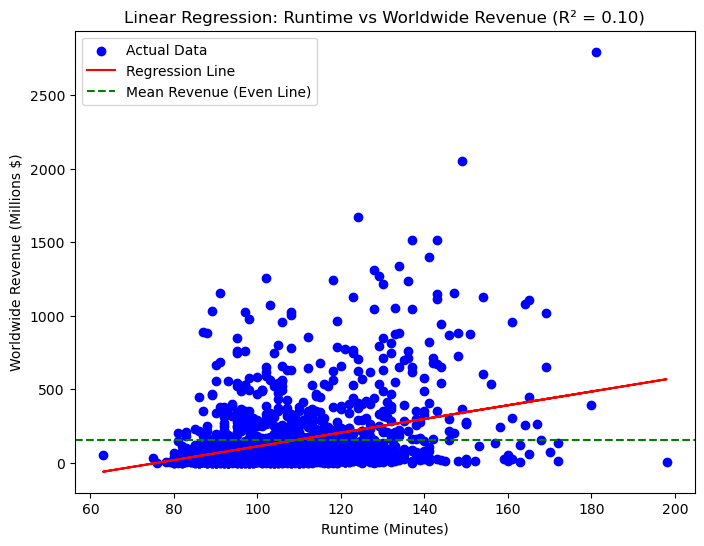

In [216]:
# Prepare data
X_runtime = merged_df_cleaned[['runtime_minutes_x']].dropna()
y_revenue = merged_df_cleaned[['Worldwide gross $']].dropna() / 1e6  # Convert to millions

# Align indices of X and y
X_runtime = X_runtime.loc[y_revenue.index]
y_revenue = y_revenue.loc[X_runtime.index]

# Create and fit the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_runtime, y_revenue)

# Predict and calculate R-squared
y_pred_revenue = lin_reg.predict(X_runtime)
r_squared_revenue = lin_reg.score(X_runtime, y_revenue)

# Calculate the mean of the revenue for the even line (convert to scalar using .item())
mean_revenue = y_revenue.mean().item()

# Plot the regression results
plt.figure(figsize=(8, 6))
plt.scatter(X_runtime, y_revenue, color='blue', label='Actual Data')
plt.plot(X_runtime, y_pred_revenue, color='red', label='Regression Line')

# Add an "even line" (mean of the dependent variable, i.e., mean revenue)
plt.axhline(y=mean_revenue, color='green', linestyle='--', label='Mean Revenue (Even Line)')

plt.xlabel('Runtime (Minutes)')
plt.ylabel('Worldwide Revenue (Millions $)')
plt.title(f'Linear Regression: Runtime vs Worldwide Revenue (R² = {r_squared_revenue:.2f})')
plt.legend()
plt.show()



>1. Regression Line:
> The red line represents the regression line, which shows a positive correlation between runtime and worldwide revenue. As the runtime increases, the movie's revenue tends to increase, but the slope of the line is quite shallow. This suggests that longer movies tend to generate slightly more revenue, but the effect is not very strong.
>
>2. R² Value:
>The R² value is 0.10, indicating that only 10% of the variance in worldwide revenue can be explained by the runtime. This suggests that runtime alone is not a significant predictor of revenue, and other factors (such as genre, marketing, or star power) may play a much larger role in determining a movie's box office success.
>
>3. Mean Revenue (Even Line):
The green dashed line represents the mean revenue across the dataset. The regression line shows that movies with runtimes longer than approximately 110 minutes tend to generate more revenue than the average movie.
>
>4. Insight: While there is a weak positive correlation between runtime and worldwide revenue, the low R² value implies that runtime alone is not a strong indicator of a movie's box office performance. Other elements such as production budget, genre, or the popularity of actors may have a much larger influence on a movie’s revenue. Longer movies may perform better, but this effect is not substantial enough to be a primary factor in predicting revenue.

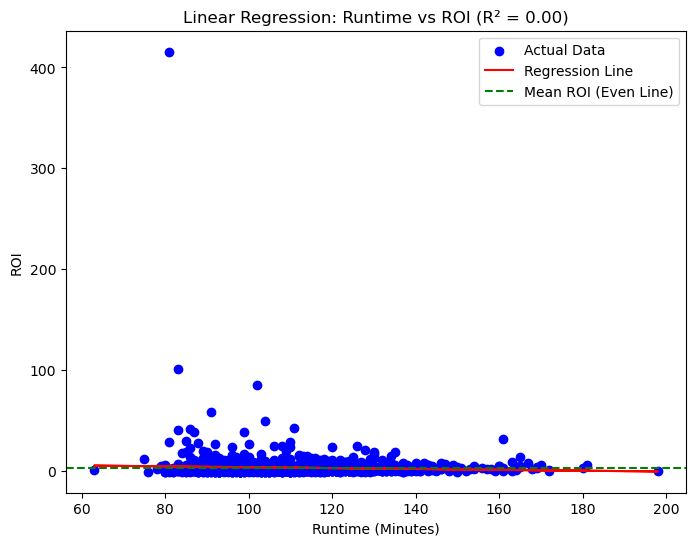

In [182]:
# Make the simple linear regression model with runtime and roi with even line
# Prepare data
X_runtime = merged_df_cleaned[['runtime_minutes_x']].dropna()
y_roi = merged_df_cleaned['ROI'].dropna()

# Align indices of X and y
X_runtime = X_runtime.loc[y_roi.index]
y_roi = y_roi.loc[X_runtime.index]

# Create and fit the linear regression model
lin_reg.fit(X_runtime, y_roi)

# Predict and calculate R-squared
y_pred_roi = lin_reg.predict(X_runtime)
r_squared_roi = lin_reg.score(X_runtime, y_roi)

# Calculate the mean of the ROI for the even line
mean_roi = y_roi.mean()

# Plot the regression results
plt.figure(figsize=(8, 6))
plt.scatter(X_runtime, y_roi, color='blue', label='Actual Data')
plt.plot(X_runtime, y_pred_roi, color='red', label='Regression Line')

# Add an "even line" (mean of the dependent variable, i.e., mean ROI)
plt.axhline(y=mean_roi, color='green', linestyle='--', label='Mean ROI (Even Line)')

plt.xlabel('Runtime (Minutes)')
plt.ylabel('ROI')
plt.title(f'Linear Regression: Runtime vs ROI (R² = {r_squared_roi:.2f})')
plt.legend()
plt.show()



> 1. Regression Line:
>The red line represents the regression line, indicating a very flat and near-zero relationship between runtime and ROI. This suggests that runtime does not significantly affect a movie’s ROI.
>
> 2. R² Value:
The R² value is 0.00, which means that 0% of the variance in ROI can be explained by the runtime. In other words, runtime is not a useful predictor for ROI.
>
> 3. Mean ROI (Even Line):
The green dashed line represents the mean ROI across all the movies. Most data points cluster around this line, indicating that most movies, regardless of runtime, tend to have ROIs close to the average.
>
> 4. Outliers:
There are a few significant outliers with extremely high ROI (above 100, and one close to 400), but these are rare. These outliers do not seem to follow any particular trend related to runtime, and they may be low-budget, high-grossing films like certain horror or indie films.
>
> 5. Insight:
There is no meaningful correlation between runtime and ROI, as indicated by the flat regression line and the low R² value. This suggests that runtime does not impact a film’s profitability in terms of ROI. Other factors, such as production budget, genre, or marketing, are likely more influential in determining a movie's return on investment.

4. Runtime vs Viewer Engagement (Number of Votes)

    4.1 T-Test

Hyphothesis : 
- Null Hypothesis(H0) : There is no significant difference in audience engagemnet between short and long runtime movies. 
- Alternative Hypothesis(H1) : There is significant difference in audience engagemnet between short and long runtime movies. 

In [115]:
# Split movies into short and long runtime categories
median_runtime = merged_df_cleaned['runtime_minutes_x'].median()
short_runtime_movies = merged_df_cleaned[merged_df_cleaned['runtime_minutes_x'] < median_runtime]
long_runtime_movies = merged_df_cleaned[merged_df_cleaned['runtime_minutes_x'] >= median_runtime]

# T-test for Number of Votes
from scipy import stats
t_stat_votes, p_val_votes = stats.ttest_ind(long_runtime_movies['movie_numerOfVotes'], short_runtime_movies['movie_numerOfVotes'], nan_policy='omit')
print(f"T-test p-value for Runtime and Viewer Engagement (Number of Votes): {p_val_votes}")


T-test p-value for Runtime and Viewer Engagement (Number of Votes): 4.845260982489372e-26


> Insights: This extremely low p-value indicates a statistically significant difference in audience engagement (number of votes) between short and long runtime movies. In this case, longer runtime films clearly engage more viewers, leading to a higher number of votes.

    4.2 Linear Regression

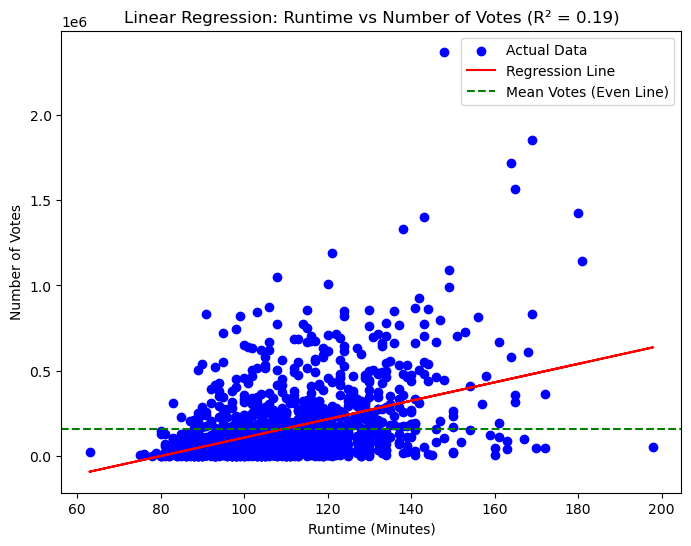

In [175]:
# Make a simple linear regression model for runtime and number of votes with evenline
# Prepare data
X_runtime = merged_df_cleaned[['runtime_minutes_x']].dropna()
y_votes = merged_df_cleaned['movie_numerOfVotes'].dropna()

# Align indices of X and y
X_runtime = X_runtime.loc[y_votes.index]
y_votes = y_votes.loc[X_runtime.index]

# Create and fit the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_runtime, y_votes)

# Predict and calculate R-squared
y_pred_votes = lin_reg.predict(X_runtime)
r_squared_votes = lin_reg.score(X_runtime, y_votes)

# Calculate the mean of the votes for the even line
mean_votes = y_votes.mean()

# Plot the regression results
plt.figure(figsize=(8, 6))
plt.scatter(X_runtime, y_votes, color='blue', label='Actual Data')
plt.plot(X_runtime, y_pred_votes, color='red', label='Regression Line')

# Add an "even line" (mean of the dependent variable, i.e., mean votes)
plt.axhline(y=mean_votes, color='green', linestyle='--', label='Mean Votes (Even Line)')

plt.xlabel('Runtime (Minutes)')
plt.ylabel('Number of Votes')
plt.title(f'Linear Regression: Runtime vs Number of Votes (R² = {r_squared_votes:.2f})')
plt.legend()
plt.show()


> 1. Regression Line:
> The red line represents the regression line, indicating a positive relationship between runtime and the number of votes. As the runtime increases, the number of votes also tends to increase.
>
> 2. R² Value:
>The R² value is 0.19, meaning that 19% of the variance in the number of votes can be explained by the runtime. While this is not a very strong correlation, it indicates that longer movies tend to receive more audience engagement in terms of votes.
>
> 3. Mean Number of Votes (Even Line):
> The green dashed line represents the mean number of votes across all movies. Most movies below 120 minutes tend to gather votes below this mean line, while many longer movies receive significantly more votes.
>
> 4. Outliers:
> There are a few outliers with a very high number of votes (over 1.5 million votes) and long runtimes (close to 150 minutes), suggesting that longer, highly popular movies tend to receive an exceptionally high number of votes.
>
> 5. Insight:
> Longer movies tend to receive more votes on average, indicating higher audience engagement or popularity for films with extended runtimes. However, the R² value shows that runtime alone doesn’t fully explain the variation in votes, meaning that other factors like genre, cast, or marketing may also influence audience engagement.

# Key Recommendation

## 1. Which Movie Genres Are the Most Profitable in Terms of ROI and Revenue?

** Insights:

1. Genres with the Highest ROI:
- Horror and Thriller genres consistently deliver the highest ROI. These movies are typically produced on lower budgets but manage to attract large audiences, resulting in impressive returns.

- Comedy and Drama also show relatively high ROI, especially when paired with mid-range budgets, indicating that these genres balance audience appeal and production cost well.

2. Genres with the Highest Revenue:

- Action and Adventure films dominate in terms of total revenue. These genres often feature large-scale productions and appeal to global audiences, resulting in blockbuster earnings.
- Fantasy and Sci-Fi genres also show strong performance in terms of worldwide revenue, particularly for franchises.

** Recommendations:

1. For High ROI: Focus on producing Horror and Thriller films with relatively low budgets. These genres consistently perform well financially and have lower risk due to minimal production costs.

2. For High Revenue: Invest heavily in Action, Adventure, and Fantasy films, as these genres offer the highest potential for large-scale box-office returns. These films require larger budgets but can attract global audiences and franchises.

## 2. How Does Production Budget Impact Movie Success Metrics (Ratings, ROI, and Revenue)?

** Insights:

1. Budget and Revenue:
- A clear positive correlation exists between production budget and worldwide revenue. As the budget increases, the likelihood of earning higher revenues also increases, particularly in genres like Action and Sci-Fi.

2. Budget and ROI:
- Interestingly, there is a weak correlation between production budget and ROI. This suggests that spending more does not necessarily guarantee higher profitability. In fact, low-budget films in genres like Horror and Comedy often deliver much higher ROI than big-budget films.

3. Budget and Ratings:
- Higher-budget movies, especially those in genres like Drama and Sci-Fi, tend to receive better ratings, potentially due to better production quality, acting, and special effects. However, this doesn't always translate into higher ROI.

** Recommendations:

1. Budget Strategy for Revenue: Allocate higher budgets to genres like Action, Adventure, and Sci-Fi to maximize box-office earnings, particularly when aiming for large global releases.

2. Budget Strategy for ROI: For higher profitability, focus on lower-budget genres like Horror and Comedy, as these films often provide the best return on investment. Studios should carefully balance production costs to maximize ROI.

3. Balanced Approach: Studios should invest in high-quality production for mid-budget films in genres like Drama, which tend to receive critical acclaim and better ratings, adding to long-term profitability through awards and critical reviews.

## 3. How Does Runtime Affect Success Metrics and Viewer Engagement?

** Insights:

1. Runtime and Viewer Engagement:
- Movies with longer runtimes tend to generate more votes, suggesting that longer movies attract more audience engagement. This is especially true for epic films in genres like Fantasy, Sci-Fi, and Action.

2. Runtime and Revenue:
- Longer runtime movies generally earn higher revenue, likely due to the association with bigger productions and elaborate storytelling (e.g., Avengers, Lord of the Rings). However, these longer movies come with much higher production costs, meaning they don’t always result in higher ROI.

3. Runtime and Ratings:
While longer runtimes tend to engage more viewers, they do not guarantee better ratings. There is no strong correlation between runtime and average IMDb ratings, indicating that length alone does not make a movie more favorable.

** Recommendations:

- For Audience Engagement: If the goal is to maximize audience engagement, consider producing longer movies, especially in genres like Fantasy and Action, where audiences expect extended storytelling.

- For Balanced Success: Aim for a runtime between 90 to 120 minutes. This range tends to offer a good balance between engagement and production costs, particularly for genres like Comedy and Drama.

- For Revenue Focused Films: Longer runtime movies may be a good choice when aiming for larger box-office earnings, but studios must be mindful of the higher production costs associated with these films.

### Extra Questions & Recommendations

4. Key Question: How Does Runtime Affect Success Metrics and audience engagement(Number of Votes)?

- Insights:
There is a moderate positive correlation (0.433) between runtime and viewer engagement, as measured by the number of votes a movie receives. Additionally, the T-test (p-value of 4.85e-26) confirms a significant difference in engagement between short and long runtime films, with longer movies generally attracting more votes. This suggests that longer runtime films are more engaging to audiences, likely because they offer more complex storytelling and are perceived as more immersive experiences.

- Recommendation:
The studio should prioritize longer runtimes for genres that benefit from high viewer engagement, such as Action, Adventure, and Fantasy, where longer films are more likely to attract larger audiences and generate higher levels of interest. For blockbuster releases, longer runtimes should be used strategically to enhance engagement. However, the studio should balance this with audience expectations, keeping shorter runtimes for genres like Horror or Comedy, where concise storytelling may be more appropriate for retaining viewer interest.

# Next Steps

1. Director Influence on ROI and Revenue
- Directors have a significant impact on the artistic and commercial success of a film, and analyzing the influence of specific directors on ROI and revenue could provide valuable insights.

2. Impact of Awards (Oscar, Golden Globe, etc.) on Success Metrics
- Awards recognition can significantly boost a movie's visibility, leading to higher revenue and critical acclaim.

3.  Time Trends in Genre Popularity
- Analyzing how genre profitability and audience preferences have changed over time to predict future trends.